# "[Adult Census Income](https://archive.ics.uci.edu/dataset/2/)" prediction income

This is an analysis of the 'Adult Census Income' dataset aimed to build a prediction model to distinguish between people with an income above or below 50,000 USD. Here, I briefly review the EDA process and some feature engineering. The model is not the best one that could be achieved, as more experimentation with feature generation is needed. It’s also necessary to perform feature selection, try applying factor analysis, and construct factors based on the impurity, while more carefully approaching the interpretation and selection of the final features. A deep analysis is not conducted here, only the algorithm for such approach is demonstrated with some remarks.

# Stages of work

1. [Download and initial analysis of data](#download)
   - [Initial data statistics](#stat)
   - [Missing values exploration](#miss) | [Save model for inference](#modesave)
   - [Calculate the number of categories](#catnum)
   - [Numeric correlation graph](#numcorr) | [Numeric distribution graph](#numdistr) | [Categorical distribution graph](#catdistr)
   - [Income distribution by features](#incomedistr)
   - [Income share by category in feature](#incomeshare)
   - [Bivariate feature graph](#bivarfeat)
   - [Box plots and outliers](#outliers)
2. [Data transformation and feature selection](#datatrans)
   - [Standard scaler](#stdscaler)
   - [Outlier processing](#removeoutliers)
   - [Create new features (Age and Working Hours)](#agework)
   - [Feature selection explanation](#featureselection)
3. [Model development](#modeldevelop)
   - [Data preparation (+ label mapping)](#datprep)
   - [Model experimentation](#modelchoos)
   - [Metrics for different models (F1, recall, ROC curve)](#modelchoosmetrics)
4. [Model training](#modeltraining)

5. [Results](#result)
   - [Best model metrics](#resmetr)
   - [ROC curve](#resroc)
6. [Conclusion](#conclusion)

7. [Save model and auxiliary data](#saveall)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.linear_model  import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier
from ucimlrepo import fetch_ucirepo
import copy
import warnings
import pickle


<a id="download"></a>
## Download and initial analysis data

In [3]:
# fetch dataset
adult = fetch_ucirepo(id=2)

# data (as pandas dataframes)
X = adult.data.features
y = adult.data.targets

df = pd.concat([X, y], axis=1)
df[df == '?'] = np.nan
df = df.drop_duplicates()

# split on the Train and test data
index_test = df[(df['income'] == '<=50K.') | (df['income'] =='>50K.')].index
index_train = df[(df['income'] == '<=50K') | (df['income'] =='>50K')].index


<a id="stat"></a>
Data type and descriptive statistics

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48813 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48813 non-null  int64 
 1   workclass       46014 non-null  object
 2   fnlwgt          48813 non-null  int64 
 3   education       48813 non-null  object
 4   education-num   48813 non-null  int64 
 5   marital-status  48813 non-null  object
 6   occupation      46004 non-null  object
 7   relationship    48813 non-null  object
 8   race            48813 non-null  object
 9   sex             48813 non-null  object
 10  capital-gain    48813 non-null  int64 
 11  capital-loss    48813 non-null  int64 
 12  hours-per-week  48813 non-null  int64 
 13  native-country  47957 non-null  object
 14  income          48813 non-null  object
dtypes: int64(6), object(9)
memory usage: 6.0+ MB


In [5]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,48813.000000,4.881300e+04,48813.000000,48813.000000,48813.000000,48813.000000
mean,38.647348,1.896679e+05,10.078688,1079.708705,87.554299,40.425051
std,13.709005,1.056062e+05,2.570257,7454.185982,403.118605,12.390954
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175550e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781400e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376200e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


<a id="miss"></a>
**Explore missing values**

In [6]:
col_missing = []

# derive features with missing values an calculate percentage
for col in df.columns:
    if df[df[col].isna()].shape[0] != 0:
        df_train = df[df.index.isin(index_train)]
        df_test = df[df.index.isin(index_test)]
        print(f"{col} has {df[df[col].isna()].shape[0]} missing values ({round(df[df[col].isna()].shape[0] / df.shape[0], 3)}%)")
        print(f"--Train {col} has {df_train[df_train[col].isna()].shape[0]}({round(df_train[df_train[col].isna()].shape[0] / df_train.shape[0], 3)}%) missing values")
        print(f"--Test {col} has {df_test[df_test[col].isna()].shape[0]}({round(df_test[df_test[col].isna()].shape[0] / df_test.shape[0], 3)}%) missing values")
        print('\n')
        col_missing.append(col)


# fill in missing values (mode only from train, to prevent data leakage)
for col in col_missing:
    missing_val = df[df.index.isin(index_train)][col].mode().iloc[0]
    df.fillna({col: missing_val}, inplace = True)

workclass has 2799 missing values (0.057%)
--Train workclass has 1836(0.056%) missing values
--Test workclass has 963(0.059%) missing values


occupation has 2809 missing values (0.058%)
--Train occupation has 1843(0.057%) missing values
--Test occupation has 966(0.059%) missing values


native-country has 856 missing values (0.018%)
--Train native-country has 582(0.018%) missing values
--Test native-country has 274(0.017%) missing values




<a id="modesave"></a>
**This is the first major point.** We have 3 features with missing values, and there are different scenarios to consider. In real projects, processing missing values is directly connected with model training and model selection. In other words, we could consider the processing of missing values as a form of hyperparameter optimization, which influences the model's performance. Here, I list some available scenarios that could be applied:
- Fill in the missing values with the most frequent values.
- Create a dummy variable to indicate missing and present data.
- Develop a model to predict missing values (using that feature as a target and creating a classifier to predict the class).
- Use a clustering technique without the feature that has missing values, then fill those values based on the class of the neighbors in that space.
- And even delete that observations.
- Research the dataset to derive dependencies between missing values and other feature.

***Based on the percentage of missing values, I decided to fill in the missing values with the most frequent values.***

P.S. For missing values during inference, I will use the mode feature from the dataset.


In [7]:
mode_values = {}
mode_values_df = df[df.index.isin(index_train)].mode()
for col in mode_values_df.columns:
    mode_values[col] = mode_values_df[col].iloc[0]

**Change target mark. I replace by 0 category '<=50K' and category '>50K' by 1**

In [8]:
# create 0-1 target from text
df = df.replace({'income': {'<=50K.': '0', '<=50K': '0'}})
df = df.replace({'income': {'>50K.': '1', '>50K': '1'}})

cat_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'income']
numeric_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

 <a id="catnum"></a>
Consider how much categories we have totally

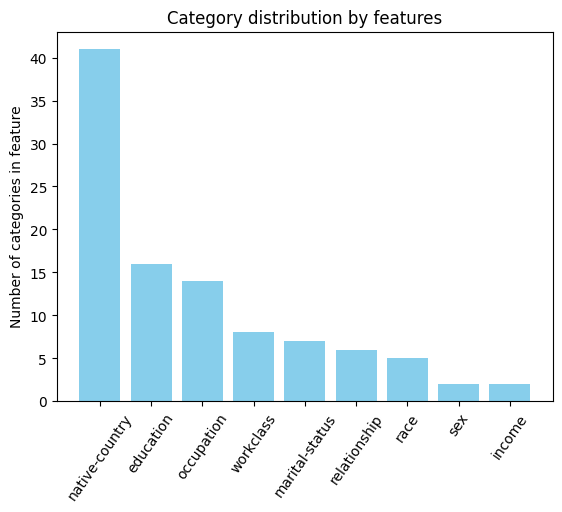

Total number of categories: 101


In [9]:
# get category instead of Object type
for col in cat_features:
    df[col] = df[col].astype('category')


# calculate number of all categories
cat_sum_number = 0
dct = {}

for col in cat_features:
    dct[col] = len(pd.unique(df[col]))
    cat_sum_number += pd.unique(df[col]).shape[0]


# plot number of categories
sorted_counts = sorted(dct.items(), key = lambda x: x[1], reverse = True)
features, counts = zip(*sorted_counts)
plt.bar(features, counts, color='skyblue')
plt.ylabel('Number of categories in feature')
plt.xticks(rotation=55)
plt.title('Category distribution by features')
plt.show()

print('Total number of categories:',cat_sum_number)

# Lets plot graph for features

<a id="numcorr"></a>
Plot correlation for numeric features. We can see that them doesn't correlate much

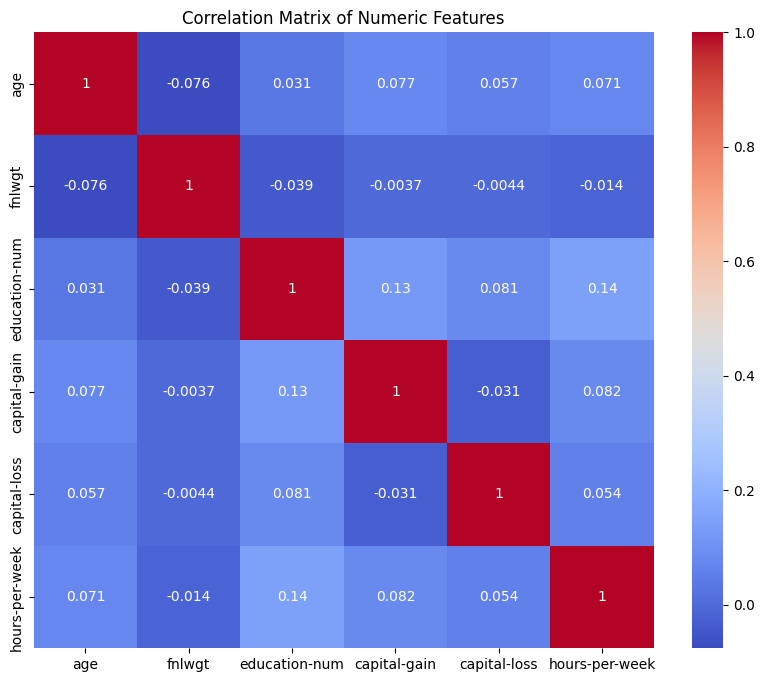

In [10]:
# plot correlation for numeric features
correlation_matrix = df[numeric_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm')
plt.title('Correlation Matrix of Numeric Features')
plt.show()

<a id="numdistr"></a>
**Plot our feature distribution**

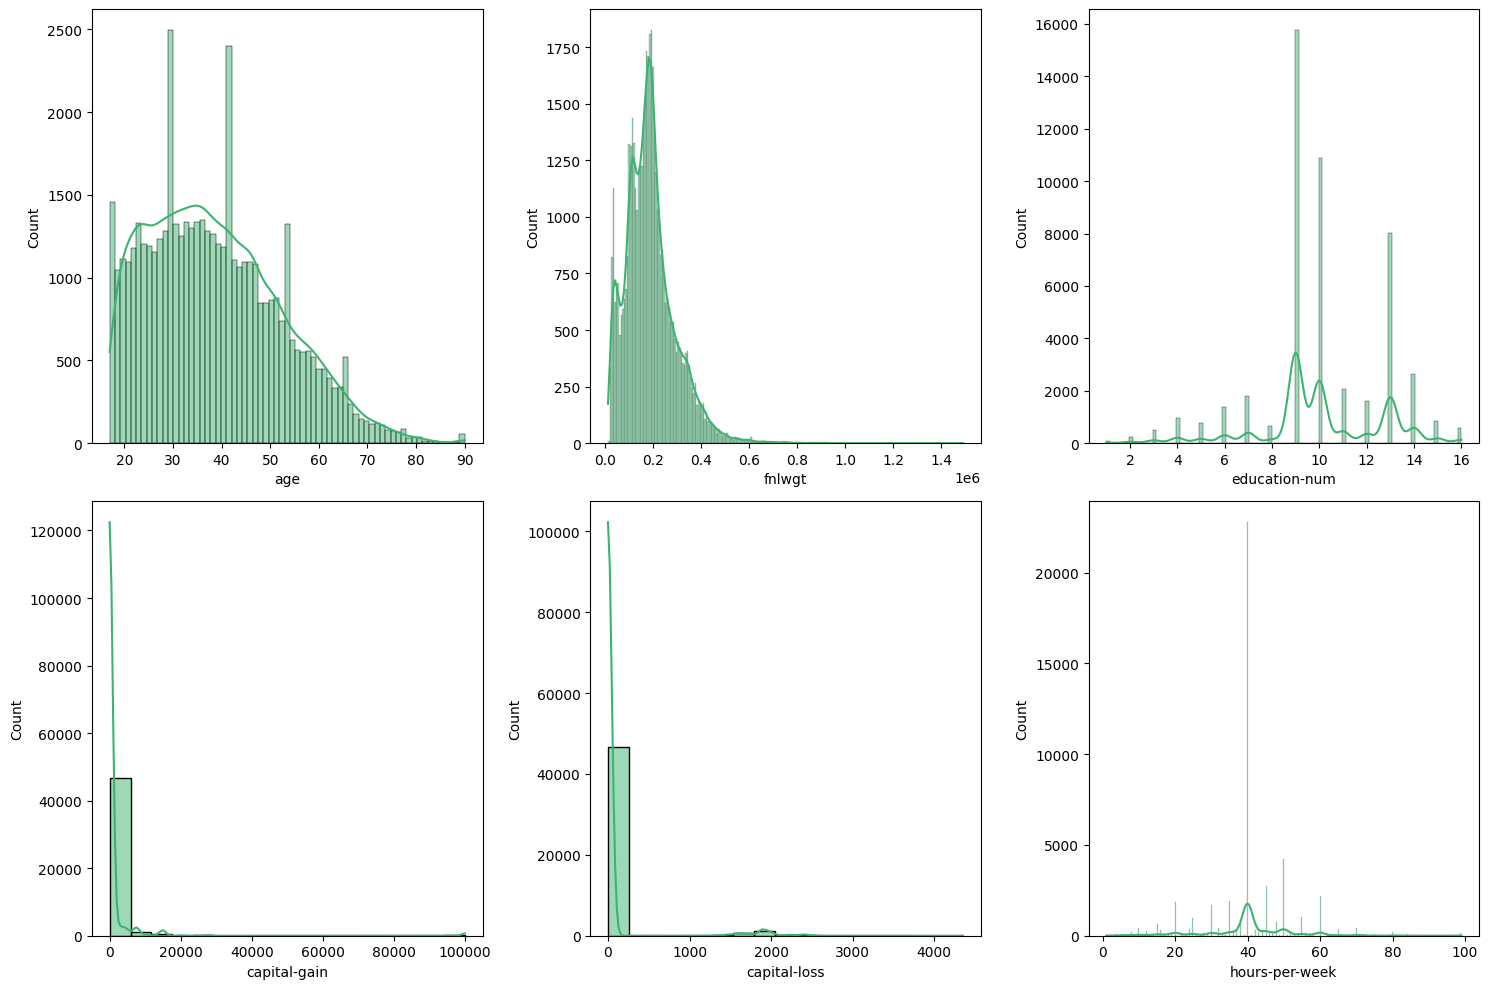

In [11]:
# plot histograms for numeric features

row_s = 2
col_s = 3

fig, axes = plt.subplots(row_s,
                         col_s,
                         figsize = (15, 10))
for i in range(row_s):
    for j in range(col_s):
        sns.histplot(df[numeric_features[i*col_s+j]],
                     kde = True,
                     ax = axes[i, j],
                     color = '#3CB371')
plt.tight_layout()
plt.show()


<a id="catdistr"></a>

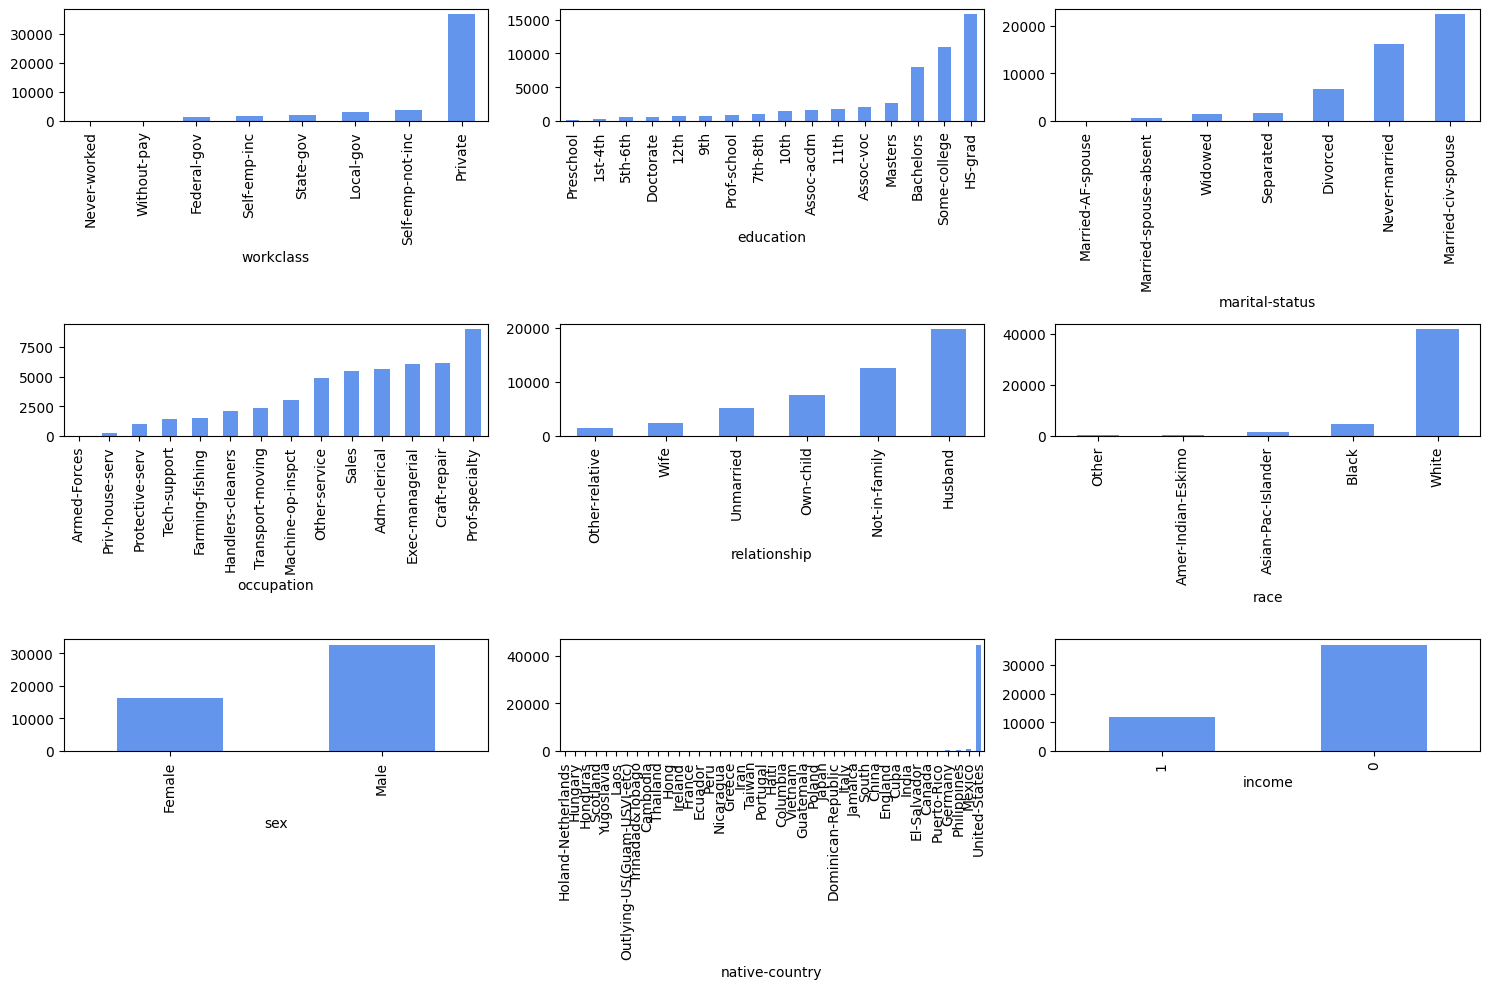

In [12]:
# plot histograms for categorical features

row_s = 3
col_s = 3

fig, axes = plt.subplots(row_s,
                         col_s,
                         figsize = (15, 10))
for i in range(row_s):
    for j in range(col_s):
        df[cat_features[i*col_s+j]].value_counts().sort_values().plot.bar(ax = axes[i, j], color = '#6495ED')
plt.tight_layout()
plt.show()


<a id="incomedistr"></a>
Let's consider income depending on the distribution of the feature's attribute

In [14]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

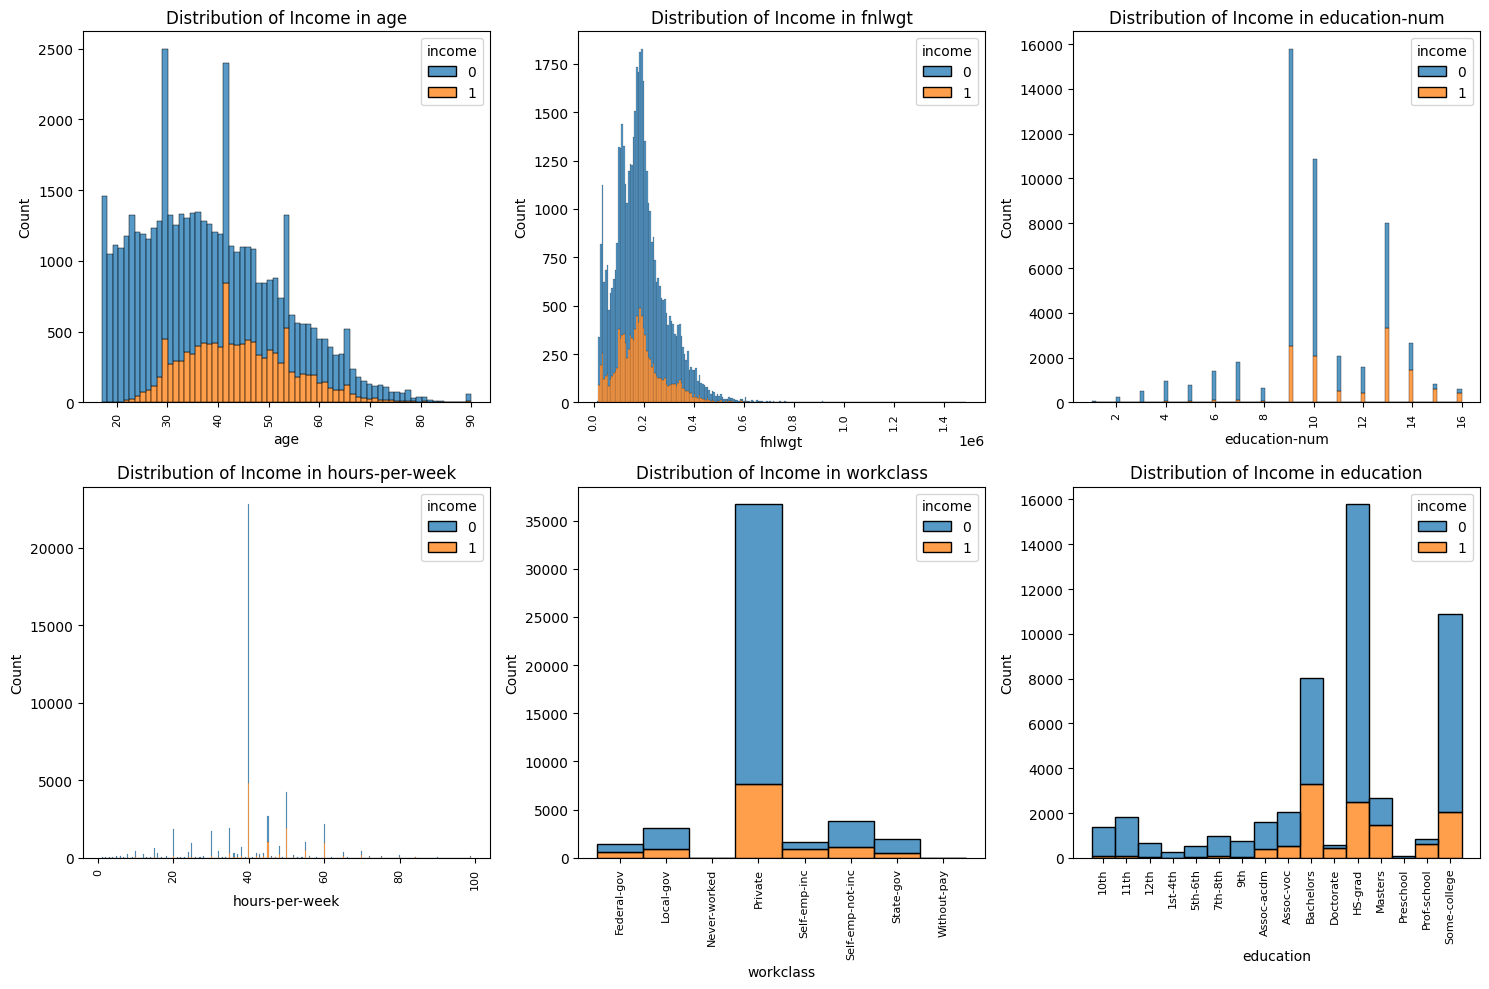

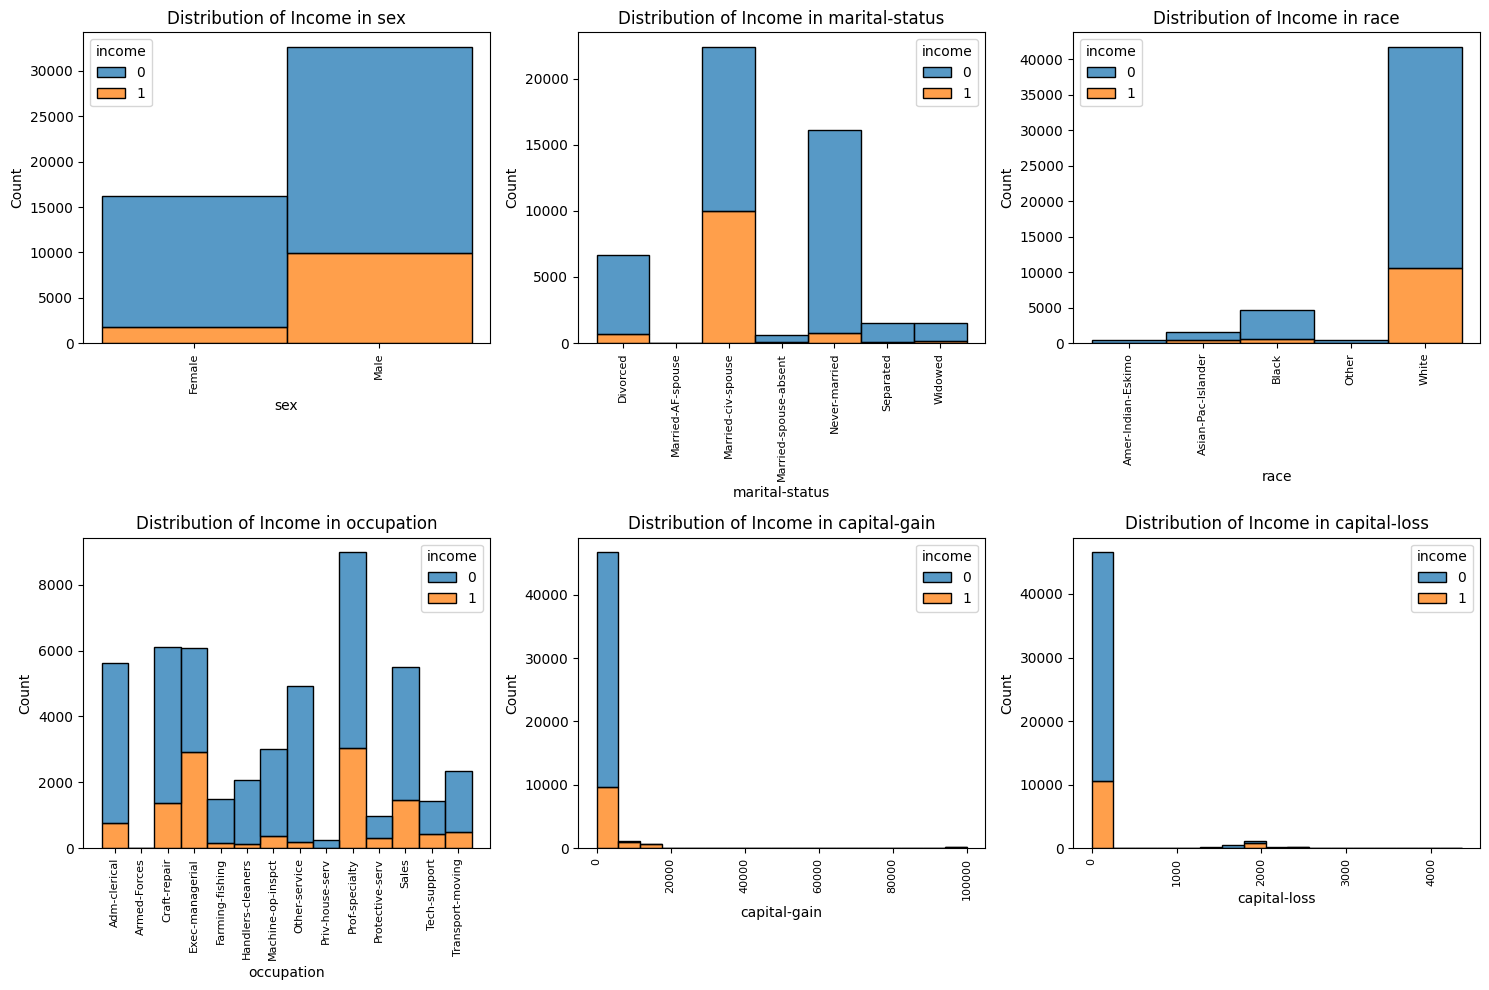

In [15]:
warnings.filterwarnings('ignore', category=FutureWarning)

# plot for feature distribution
def plot_income_hist_distribution(col_name, df):

    fig, ax = plt.subplots(figsize = (12, 6))
    ax = sns.histplot(x = col_name,
                      data = df,
                      hue = 'income',
                      multiple = 'stack')
    plt.title(col_name + ' distribution')
    plt.xlabel(col_name)
    plt.xticks(fontsize=8)
    plt.xticks(rotation=90)
    plt.ylabel('Histogram of income >50k(1) and <=50k(0)')
    plt.legend(title='income')
    plt.show();


# plot income - the feature's attribute
row_s = 2
col_s = 3
plot_features = ['age', 'fnlwgt', 'education-num', 'hours-per-week', 'workclass', 'education',
                 'sex', 'marital-status', 'race', 'occupation', 'capital-gain', 'capital-loss']


fig, ax = plt.subplots(row_s,
                       col_s,
                       figsize = (15, 10))
for i in range(row_s):
    for j in range(col_s):

        sns.histplot(x = plot_features[i * col_s + j],
                     data = df,
                     hue = 'income',
                     multiple = 'stack',
                     ax = ax[i, j])
        ax[i, j].tick_params(axis = 'x',
                             labelsize = 8)

        for label in ax[i, j].get_xticklabels():
            label.set_rotation(90)
        ax[i, j].set_title(f'Distribution of Income in {plot_features[i * col_s + j]}')

plt.tight_layout()
plt.show()


fig, ax = plt.subplots(row_s,
                       col_s,
                       figsize = (15, 10))
for i in range(row_s):
    for j in range(col_s):

        sns.histplot(x = plot_features[(i + 2) * col_s + j],
                     data = df,
                     hue = 'income',
                     multiple = 'stack',
                     ax = ax[i, j])
        ax[i, j].tick_params(axis = 'x',
                             labelsize = 8)

        for label in ax[i, j].get_xticklabels():
            label.set_rotation(90)
        ax[i, j].set_title(f'Distribution of Income in {plot_features[(i + 2) * col_s + j]}')

plt.tight_layout()
plt.show()

<a id="incomeshare"></a>
Lets consider shares of income in each group of category

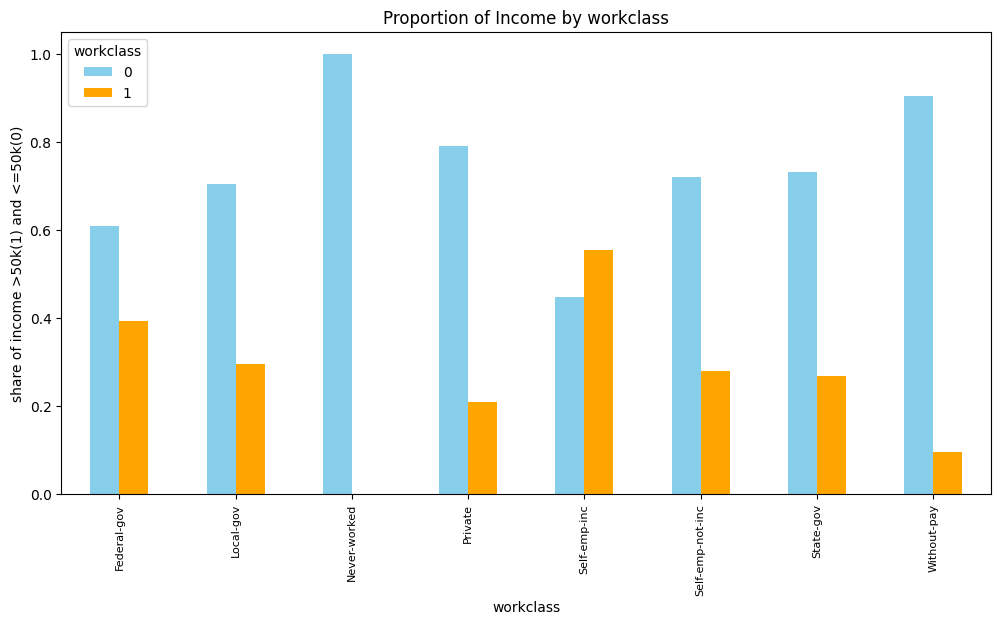

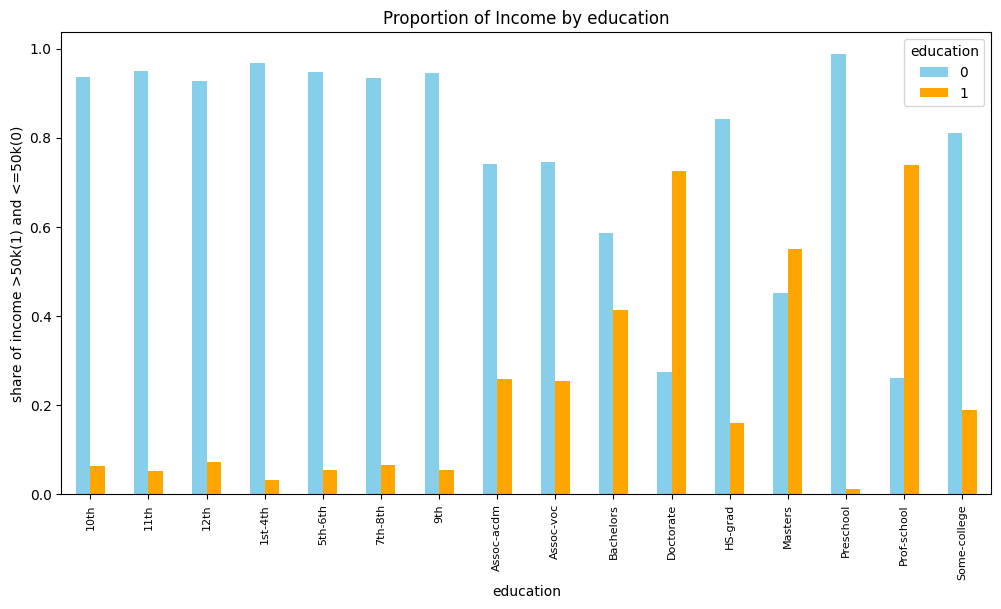

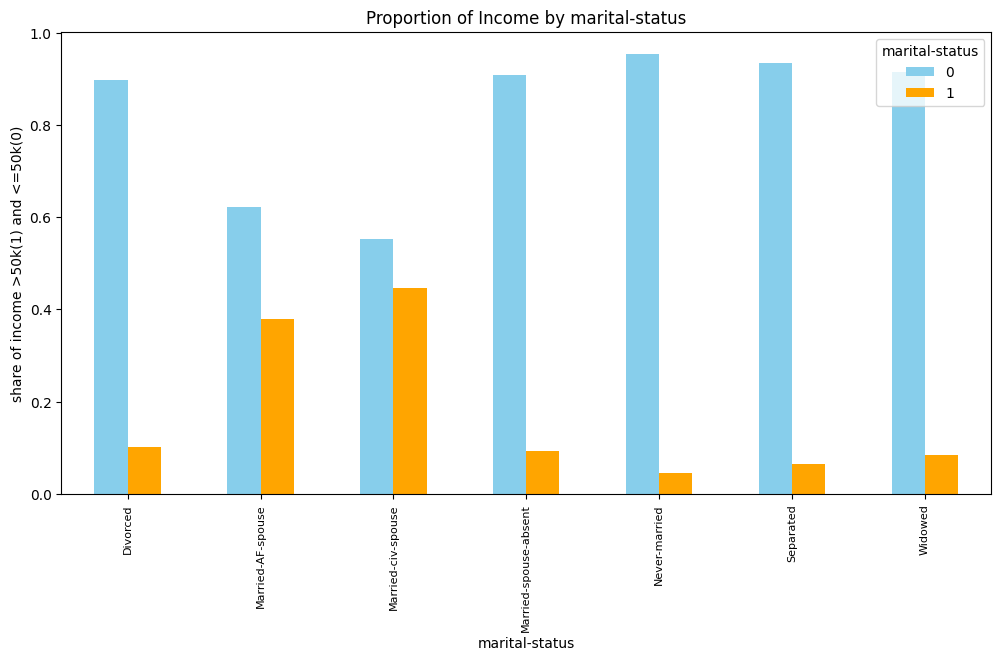

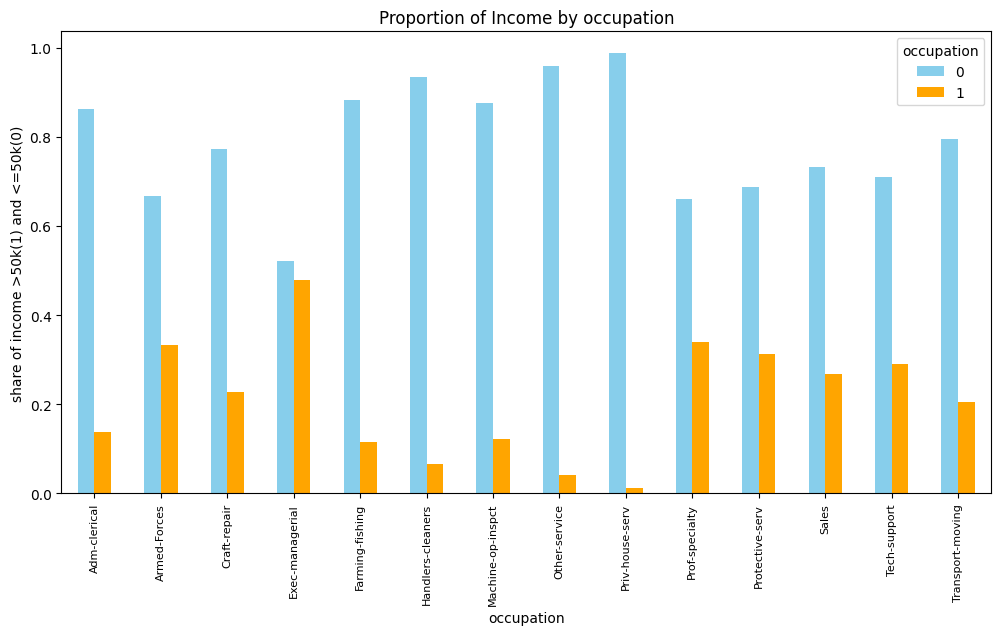

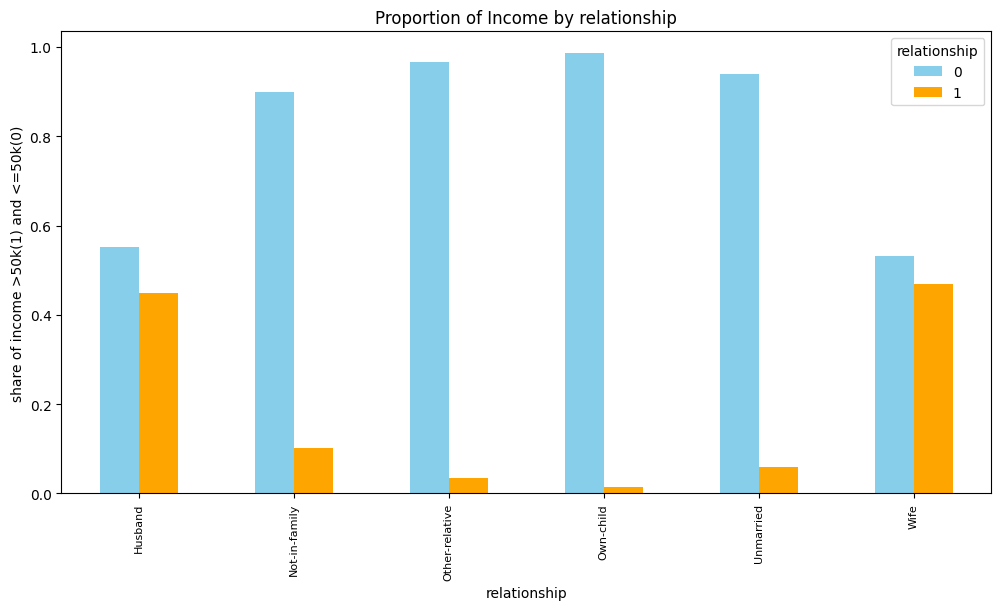

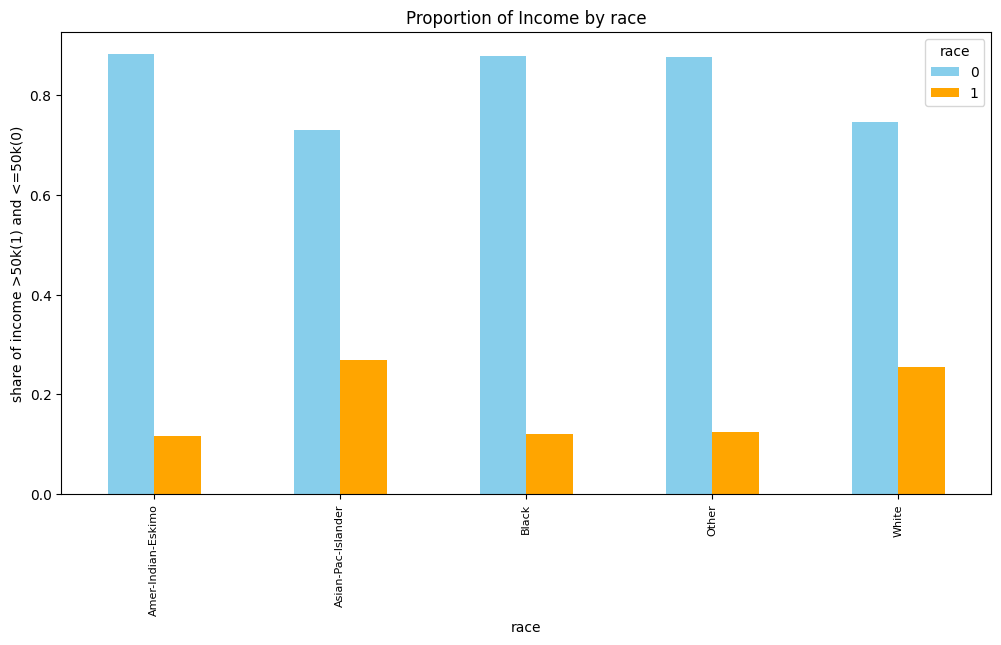

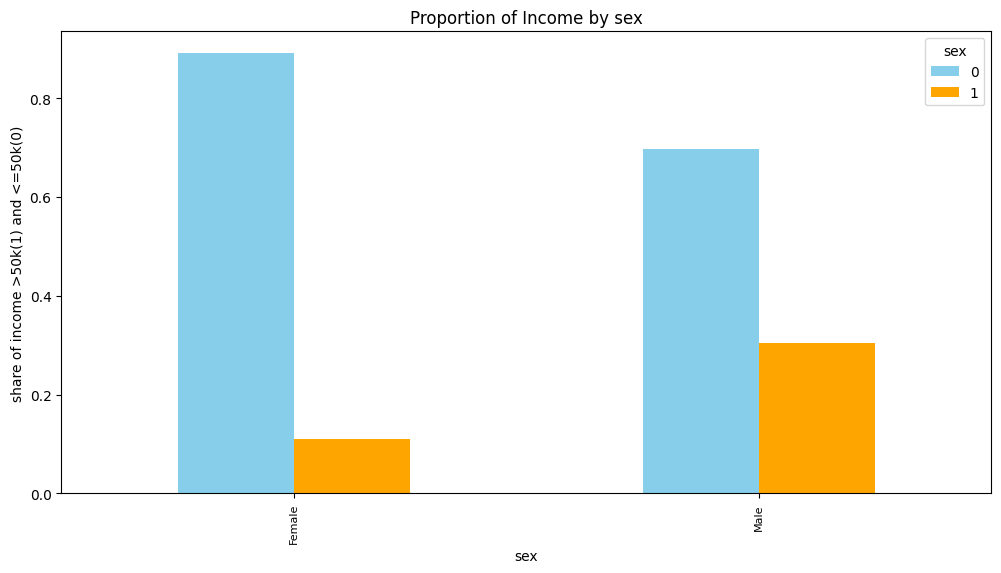

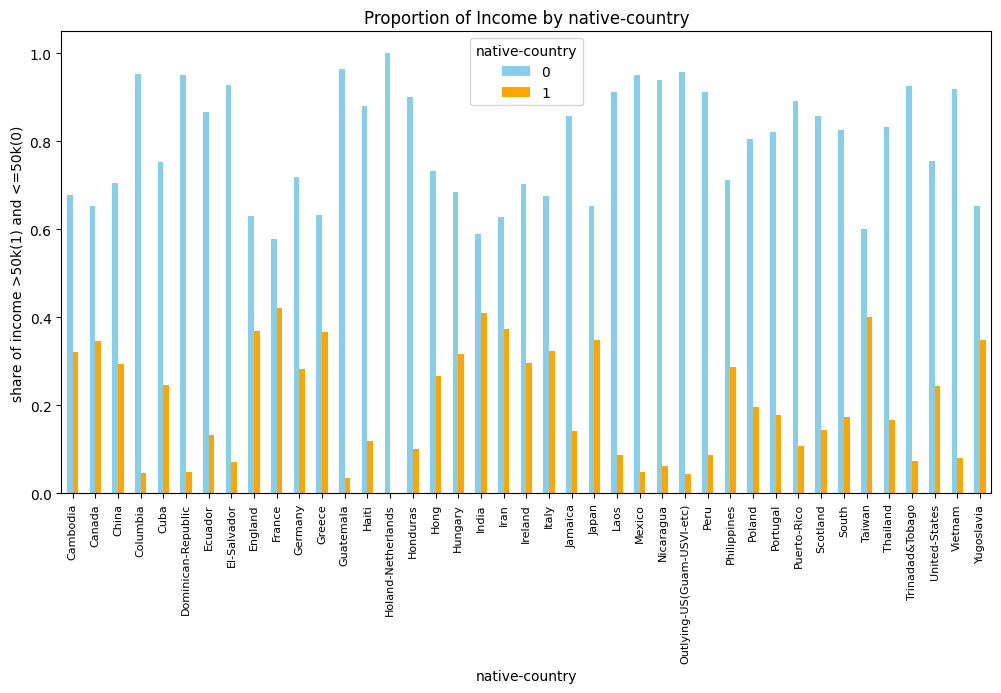

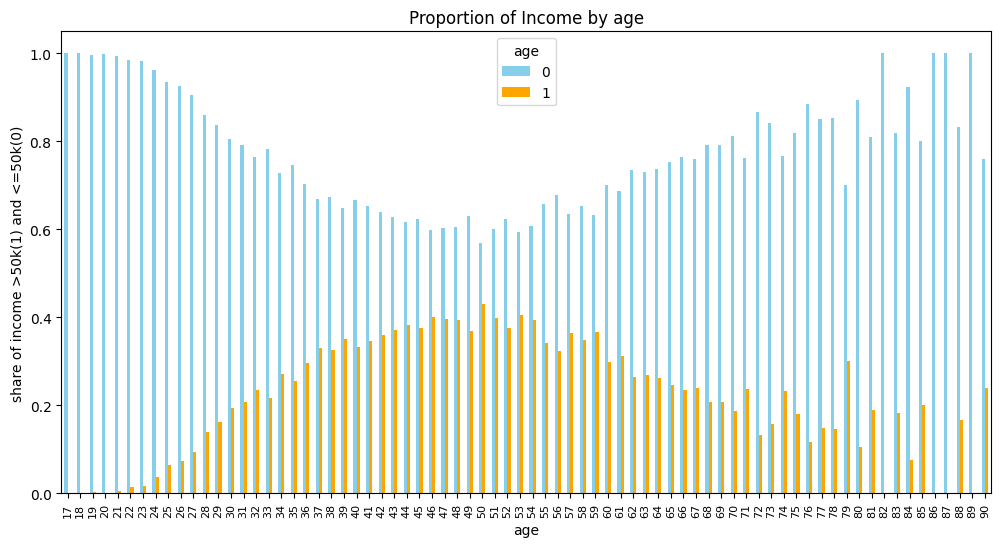

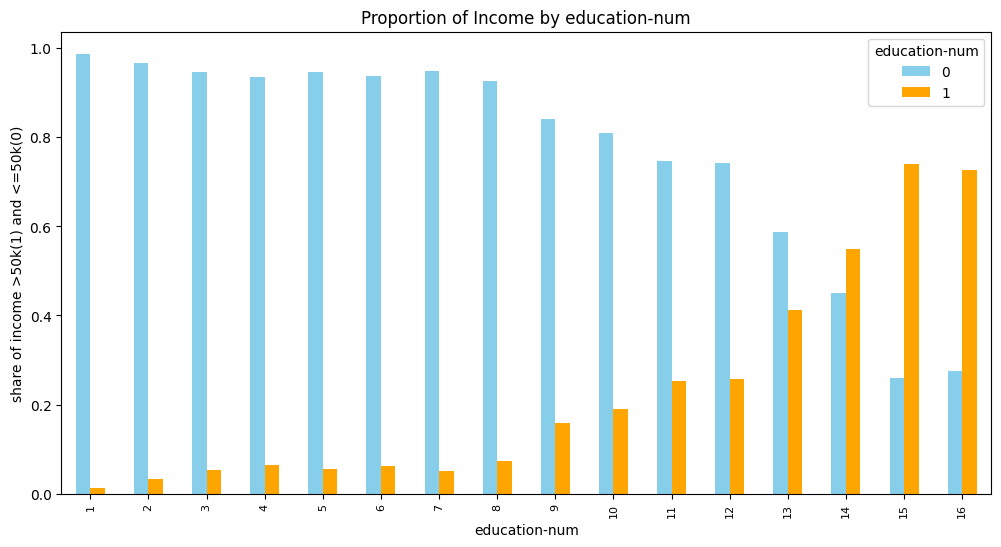

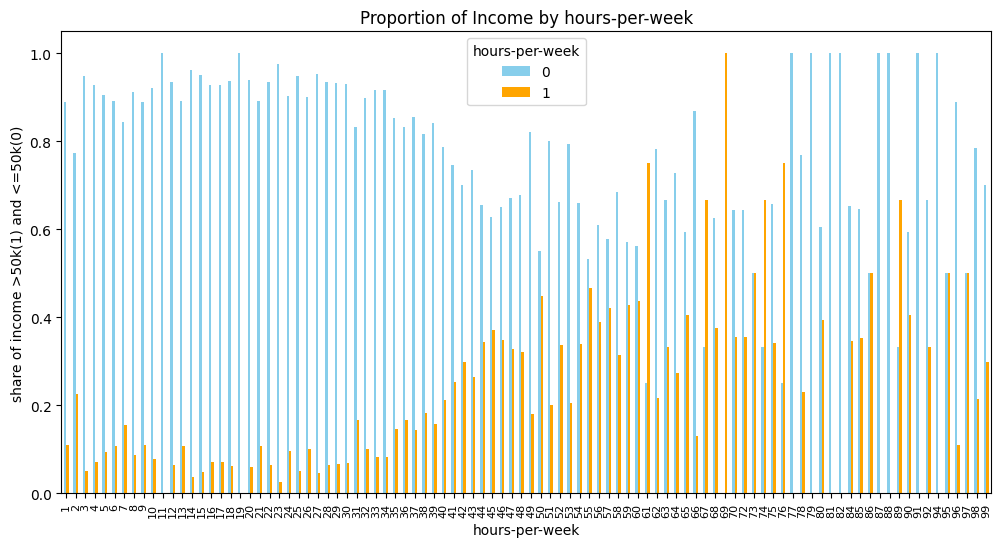

In [16]:
warnings.filterwarnings('ignore', category=FutureWarning)

# function for plot distribution share by Income
def plot_income_share_distribution(col_name, df):

    fig, ax = plt.subplots(figsize = (12, 6))
    feature_counts = df.groupby([col_name, 'income']).size().unstack()
    feature_proportions = feature_counts.div(feature_counts.sum(axis = 1), axis = 0)
    feature_proportions.plot(kind = 'bar',
                             color = ['skyblue', 'orange'],
                             ax = ax)
    plt.title('Proportion of Income by ' + col_name)
    plt.xlabel(col_name)
    plt.ylabel('share of income >50k(1) and <=50k(0)')
    plt.xticks(fontsize = 8)
    plt.legend(title = col_name)
    plt.show();


# loop for categorical variables
for col in cat_features[:-1]:
    plot_income_share_distribution(col, df)

# loop for some numerical variables
for col in ['age', 'education-num', 'hours-per-week']:
    plot_income_share_distribution(col, df)

<a id="bivarfeat"></a>
Next, consider the relationship between some features and how income is distributed in relation to them.

*Capital and education*

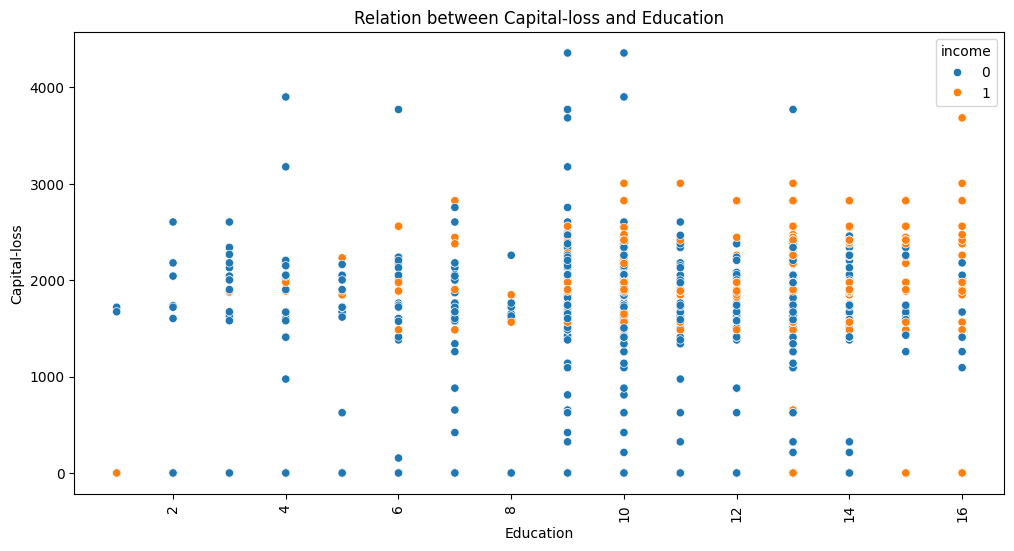

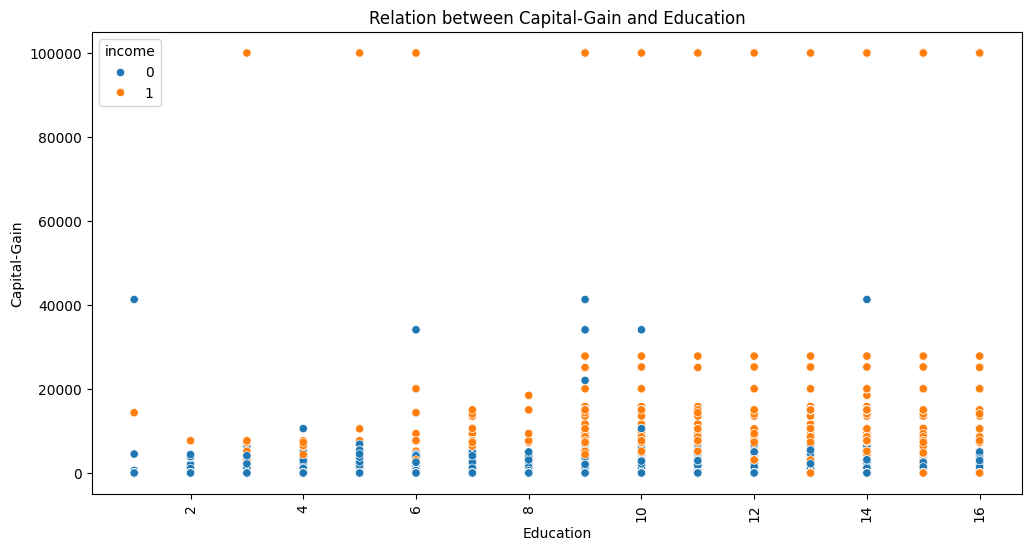

In [17]:
# Capital and education

fig, ax = plt.subplots(figsize = (12, 6))
ax = sns.scatterplot(y = df['capital-loss'],
                     x = df['education-num'],
                     hue = df['income'])
plt.xticks(rotation = 90)
plt.title('Relation between Capital-loss and Education')
plt.ylabel('Capital-loss')
plt.xlabel('Education')
plt.show()


fig, ax = plt.subplots(figsize = (12, 6))
ax = sns.scatterplot(y = df['capital-gain'],
                     x = df['education-num'],
                     hue = df['income'])
plt.xticks(rotation = 90)
plt.title('Relation between Capital-Gain and Education')
plt.ylabel('Capital-Gain')
plt.xlabel('Education')
plt.show()


*Education and Age*

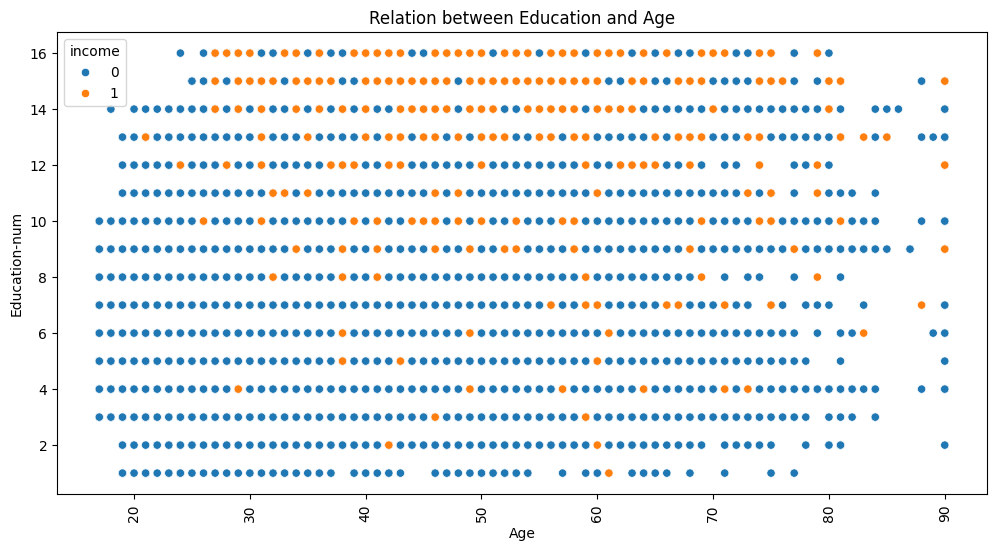

In [18]:
fig, ax = plt.subplots(figsize = (12, 6))
ax = sns.scatterplot(y = df['education-num'],
                     x = df['age'],
                     hue = df['income'])
plt.xticks(rotation = 90)
plt.title('Relation between Education and Age')
plt.ylabel('Education-num')
plt.xlabel('Age')
plt.show()

*Fnlwgt and Age*

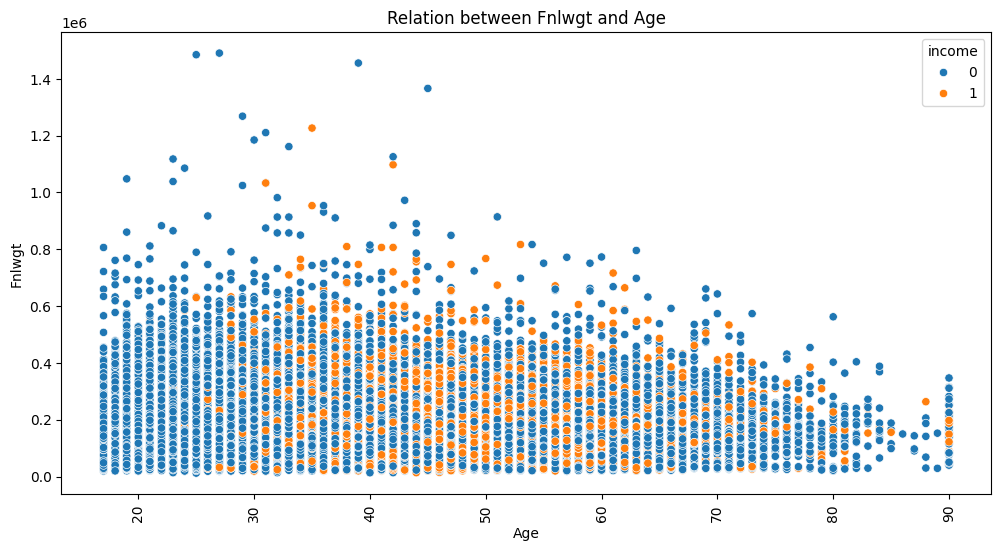

In [ ]:
fig, ax = plt.subplots(figsize = (12, 6))
ax = sns.scatterplot(y = df['fnlwgt'],
                     x = df['age'],
                     hue = df['income'])
plt.xticks(rotation = 90)
plt.title('Relation between Fnlwgt and Age')
plt.ylabel('Fnlwgt')
plt.xlabel('Age')
plt.show()

*Capital-loss and Age*

**Here is interesting relationship. We can see line structure here, wery interesting relation. Going forward, it's why we shouldn't delete all "outliers" when apply scaling for capital loss. Yes, we have a lot of zero numbers, but that values which isn't = zero are very interesting**

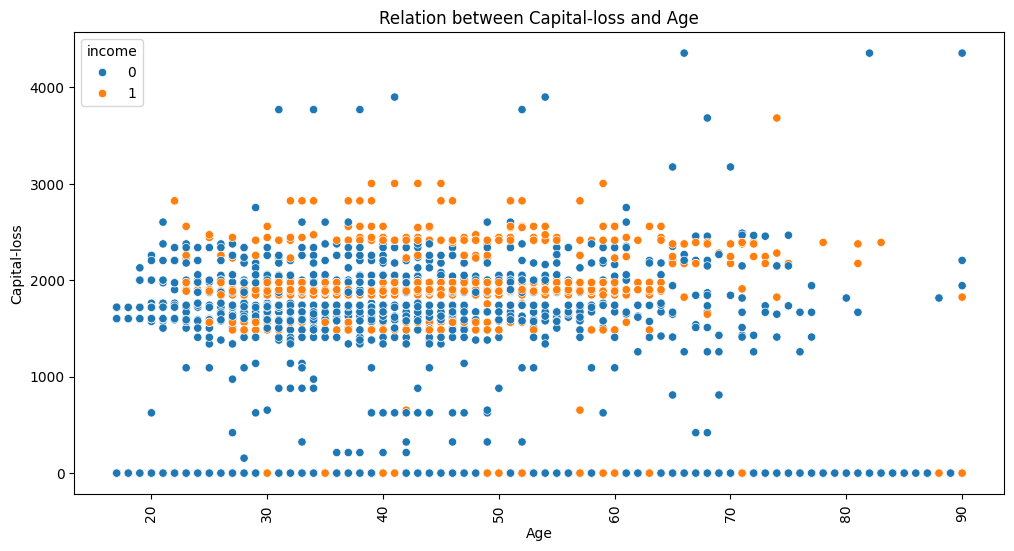

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.scatterplot(y=df['capital-loss'], x=df['age'], hue=df['income'])
plt.xticks(rotation=90)
plt.title('Relation between Capital-loss and Age')
plt.ylabel('Capital-loss')
plt.xlabel('Age')
plt.show()

In [20]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

<a id="outliers"></a>
# Outliers handling
We can see that we have outliers in data. Go forward - It's one of the reason why I start using category for model training for age and hours-per-week. Lets try to deal with capital-gain, loss and fnlwgt - log it and check the data. **For capital-gain & loss I show box plot for values != zero**

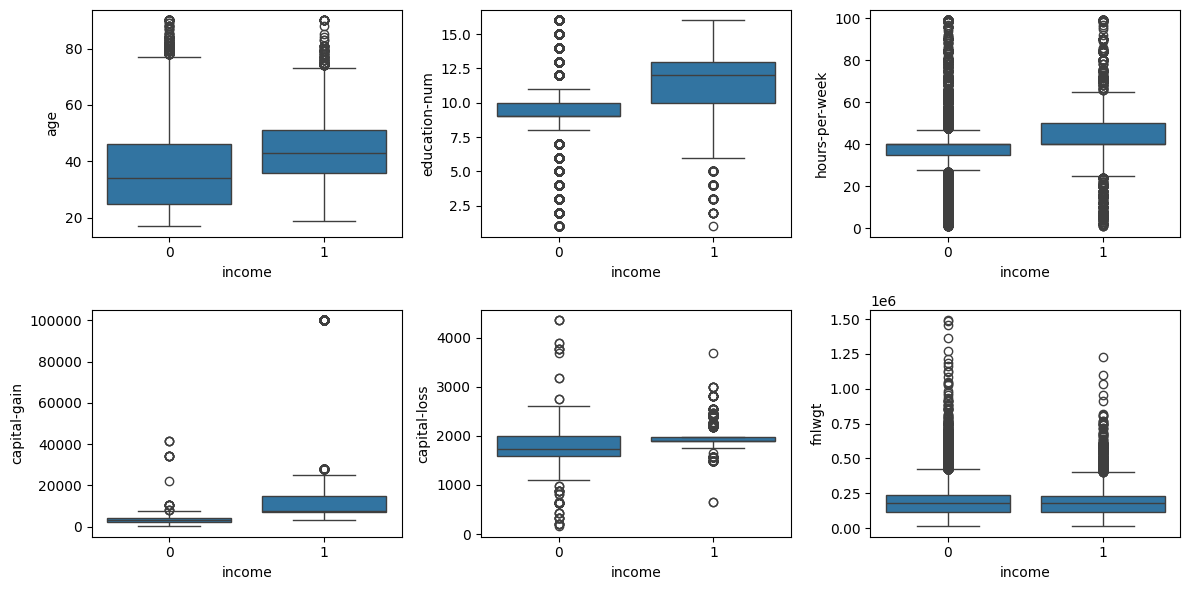

In [24]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
sns.boxplot(x = 'income', y = 'age', data = df, ax = axes[0, 0])
sns.boxplot(x = 'income', y = 'education-num', data = df, ax = axes[0, 1])
sns.boxplot(x = 'income', y = 'hours-per-week', data = df, ax = axes[0, 2])
sns.boxplot(x = 'income', y = 'capital-gain', data = df[df['capital-gain'] != 0], ax = axes[1, 0])
sns.boxplot(x = 'income', y = 'capital-loss', data = df[df['capital-loss'] != 0], ax = axes[1, 1])
sns.boxplot(x = 'income', y = 'fnlwgt', data = df, ax = axes[1, 2])

plt.tight_layout()
plt.show()

Let's consider if log values help us with outliers.
I concentrate here only on 'capital-gain', 'capital-loss' and 'fnlwgt'

In [25]:
tmp = pd.DataFrame(columns = ['income', 'capital-gain', 'capital-loss', 'fnlwgt'])
tmp['income'] = copy.deepcopy(df['income'])
tmp['capital-gain'] = np.where(df['capital-gain'] > 0, copy.deepcopy(np.log(df['capital-gain'])), 0)
tmp['capital-loss'] = np.where(df['capital-loss'] > 0, copy.deepcopy(np.log(df['capital-loss'])), 0)
tmp['fnlwgt'] = np.where(df['fnlwgt'] > 0, copy.deepcopy(np.log(df['fnlwgt'])), 0)

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


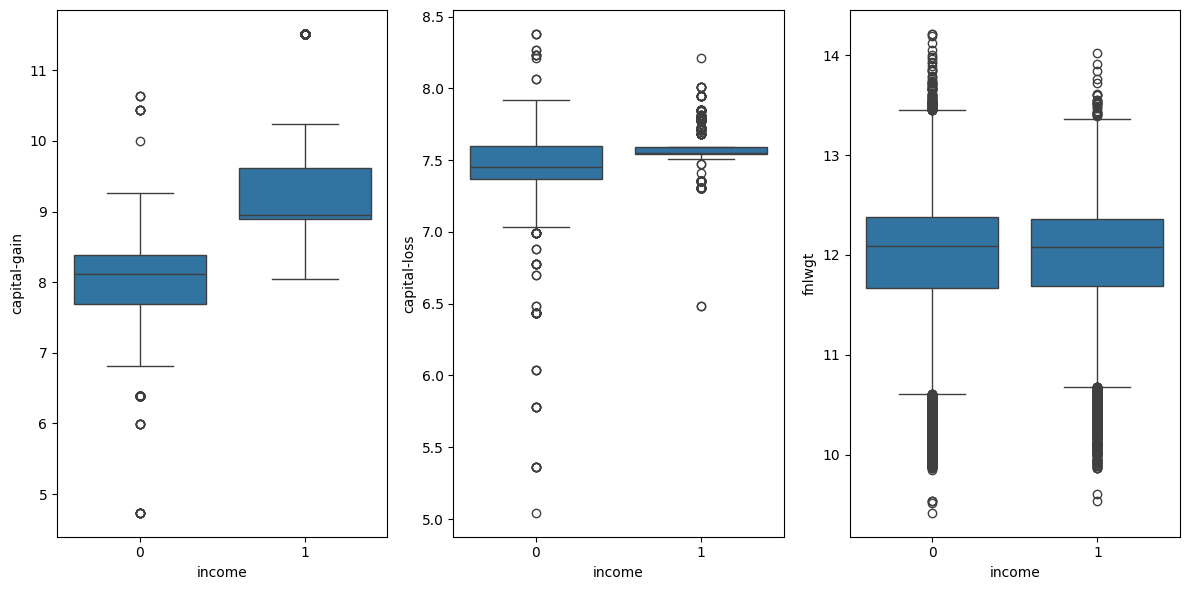

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(12, 6))
sns.boxplot(x = 'income', y = 'capital-gain', data = tmp[tmp['capital-gain'] != 0], ax = axes[0])
sns.boxplot(x = 'income', y = 'capital-loss', data = tmp[tmp['capital-loss'] != 0], ax = axes[1])
sns.boxplot(x = 'income', y = 'fnlwgt', data = tmp, ax = axes[2])

plt.tight_layout()
plt.show()

In [27]:
print('Share of non-zero capital-gain values = ', (df[df['capital-gain'] != 0].shape[0] / df.shape[0]) * 100, '%')
print('Share of non-zero capital-loss values = ', (df[df['capital-loss'] != 0].shape[0] / df.shape[0]) * 100, '%')

Share of non-zero capital-gain values =  8.266240550672975 %
Share of non-zero capital-loss values =  4.674984123081965 %


We can see that log-linearisation will not help us but we will handle outliers in feature transformation section. Here I want to notice that we have not a lot of values in capital-loss & gain which aren't = zero. And while the remaining values contain outliers, their number is still relatively low.

<a id="datatrans"></a>
# Data Transformation and feature selection

<a id="stdscaler"></a>
**Transformation**

Log transformation is not helpful, so let's work with the initial values and scale the data. We will try to handle outliers.

Firstly, removing outliers for capital-gain and capital-loss leads to constant values because most of the data have values equal to zero. Based on this, we have a strategy for future feature development. We can try using these two features in the model, just standardized.

If the performance doesn't improve, we can return to refine these features. For example, we can categorize them into zeros (marked as 0) and non-zero values (marked as 1) — in other words, create dummy variables for them. Then, we can work with the outliers and apply standardization to all values that are not equal to zero, relatively speaking.

However, I believe that good performance can be achieved without these steps, and these operations would be optimizations, not crucial changes.
For this reason, I will standardize these three features and handle outliers only for 'fnlwgt.'

I saved the mean and variance derived from the training dataset, and I have already applied them to the test data as well. I store that values and will use it in the inference

In [28]:
mean_var_store = {}
for col in ['capital-gain', 'capital-loss', 'fnlwgt']:
    scaler = StandardScaler()
    scaler.fit(pd.DataFrame(df.loc[index_train][col]))
    df[col+'_scale'] = scaler.transform(pd.DataFrame(df[col]))
    mean_var_store[col+'_mean'] = scaler.mean_[0]
    mean_var_store[col+'_var'] = scaler.var_[0]


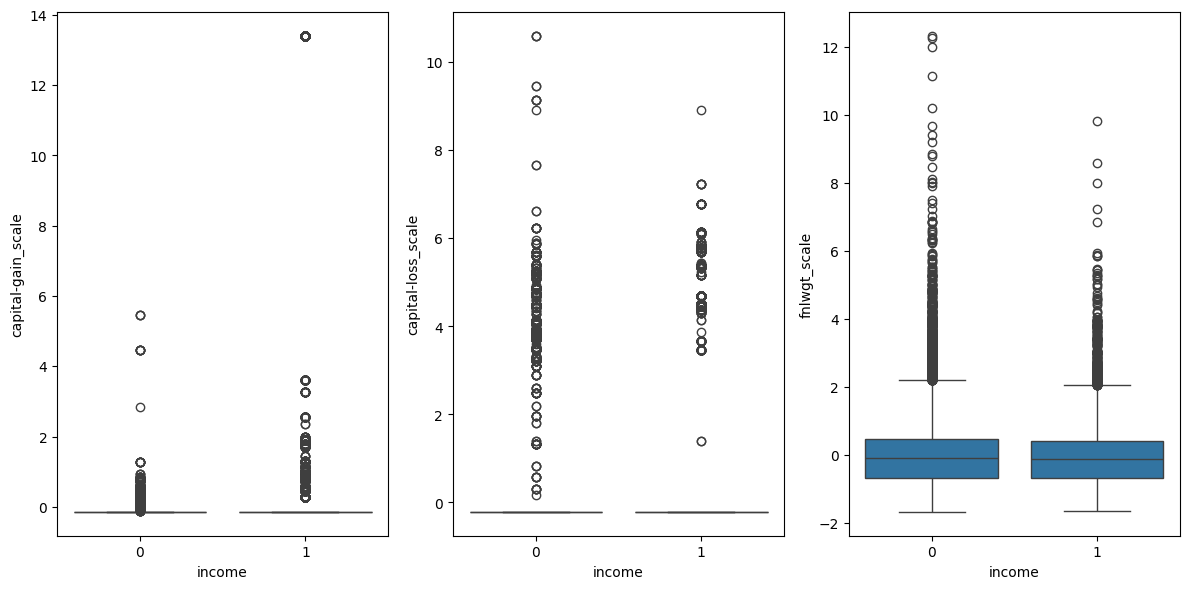

In [31]:
fig, axes = plt.subplots(1, 3, figsize = (12, 6))
sns.boxplot(x = 'income', y = 'capital-gain_scale', data = df, ax = axes[0])
sns.boxplot(x = 'income', y = 'capital-loss_scale', data = df, ax = axes[1])
sns.boxplot(x = 'income', y = 'fnlwgt_scale', data = df, ax = axes[2])

plt.tight_layout()
plt.show()

<a id="removeoutliers"></a>
*remove outliers*

Doing it now only for fnlwgt. In the deepest model development it's better to do it for the 2nd strategy for Capital-loss & gain too

In [33]:
temp_columns = ['fnlwgt_scale']

for col in temp_columns:

    data = pd.DataFrame(copy.deepcopy(df[col]))
    data_index = df.loc[index_train][col].index
    temp = 1.5
    IQR = data.loc[data_index].quantile(0.85).iloc[0] - data.loc[data_index].quantile(0.15).iloc[0]
    upper = data.loc[data_index].quantile(0.90).iloc[0] + (temp * IQR)
    lower = data.loc[data_index].quantile(0.10).iloc[0] - (temp * IQR)

    outlier_value_low = data[data[col] < lower].shape[0]
    outlier_value_up = data[data[col] > upper].shape[0]
    outlier_value_low_train = data.loc[data_index][data.loc[data_index][col] < lower].shape[0]
    outlier_value_up_train = data.loc[data_index][data.loc[data_index][col] > upper].shape[0]

    print("Column: ", col , ": " , "Upper limit: " , upper," lower limit: " , lower)
    print("below the limit shape: ", outlier_value_low, " Over border: " , outlier_value_up)
    print("below the limit shape train: ", outlier_value_low_train, " Over border train: " , outlier_value_up_train)
    print("below the limit shape test: ", outlier_value_low - outlier_value_low_train, " Over border test: " , outlier_value_up - outlier_value_up_train, "\n")

    data.loc[data[col] > upper, col] = upper
    data.loc[data[col] < lower, col] = lower

    print("After processing outliers")
    outlier_value_low = data[data[col] < lower].shape[0]
    outlier_value_up = data[data[col] > upper].shape[0]
    print("Column: ", col , ": " , "Upper limit: " , upper + 1 ," lower limit: " , lower - 1)
    print("below the limit shape: ", outlier_value_low , " Over border: " , outlier_value_up,"\n")
    print("----------------------------------------------------------------------------------\n")

    df[col] = copy.deepcopy(data[col])

Column:  fnlwgt_scale :  Upper limit:  4.129025393330384  lower limit:  -3.9848472419993044
below the limit shape:  0  Over border:  174
below the limit shape train:  0  Over border train:  115
below the limit shape test:  0  Over border test:  59 

After processing outliers
Column:  fnlwgt_scale :  Upper limit:  5.129025393330384  lower limit:  -4.984847241999304
below the limit shape:  0  Over border:  0 

----------------------------------------------------------------------------------



Plot it without outlier for fnlwgt

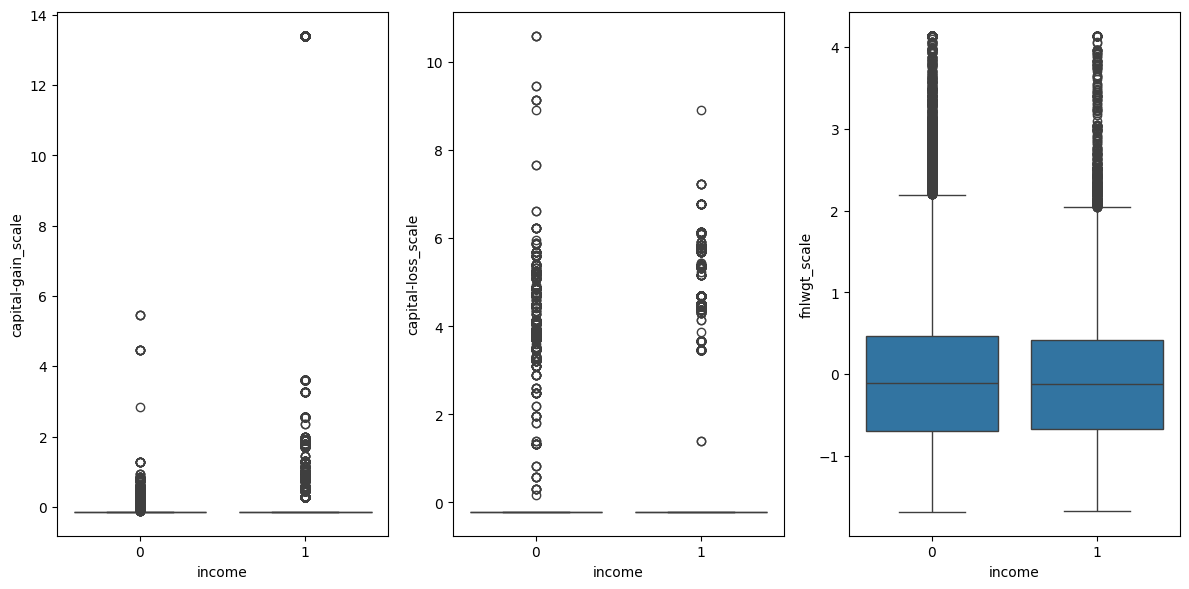

In [ ]:
fig, axes = plt.subplots(1, 3, figsize = (12, 6))
sns.boxplot(x = 'income', y = 'capital-gain_scale', data = df, ax = axes[0])
sns.boxplot(x = 'income', y = 'capital-loss_scale', data = df, ax = axes[1])
sns.boxplot(x = 'income', y = 'fnlwgt_scale', data = df, ax = axes[2])

plt.tight_layout()
plt.show()

<a id="agework"></a>
**Transform Age and working hours data into categorical**
**I decide to group them**

*Firstly, create group for working hours*

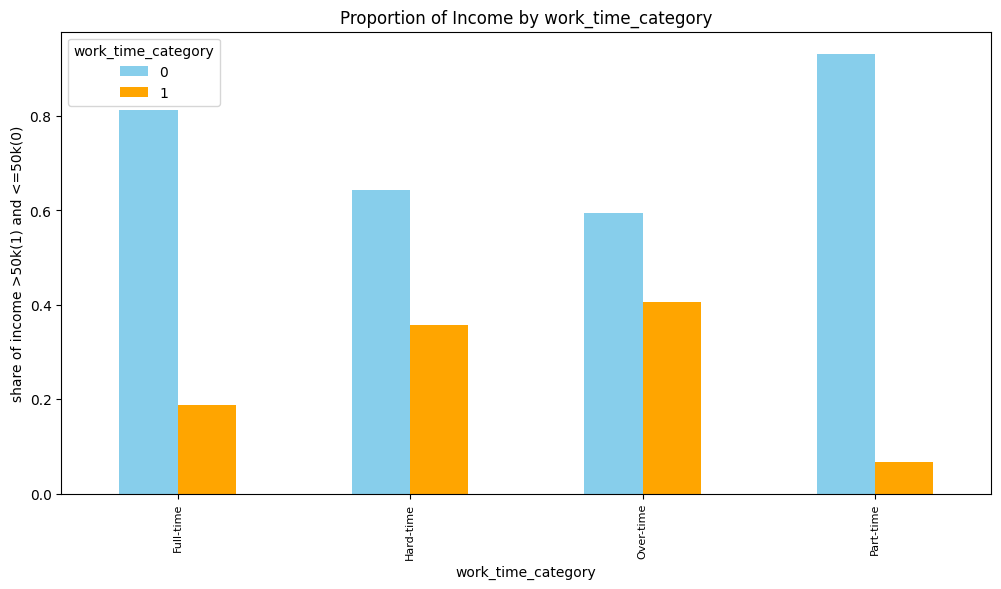

In [22]:
warnings.filterwarnings('ignore', category=FutureWarning)


# work time category
def work_time_category(hours):
    if hours <= 20:
        return 'Part-time'
    elif 20 < hours <= 40:
        return 'Full-time'
    elif 40 < hours <= 60:
        return 'Over-time'
    else:
        return 'Hard-time'


df['work_time_category'] = df['hours-per-week'].apply(work_time_category)
plot_income_share_distribution('work_time_category', df)

*Secondly, create group for age group*

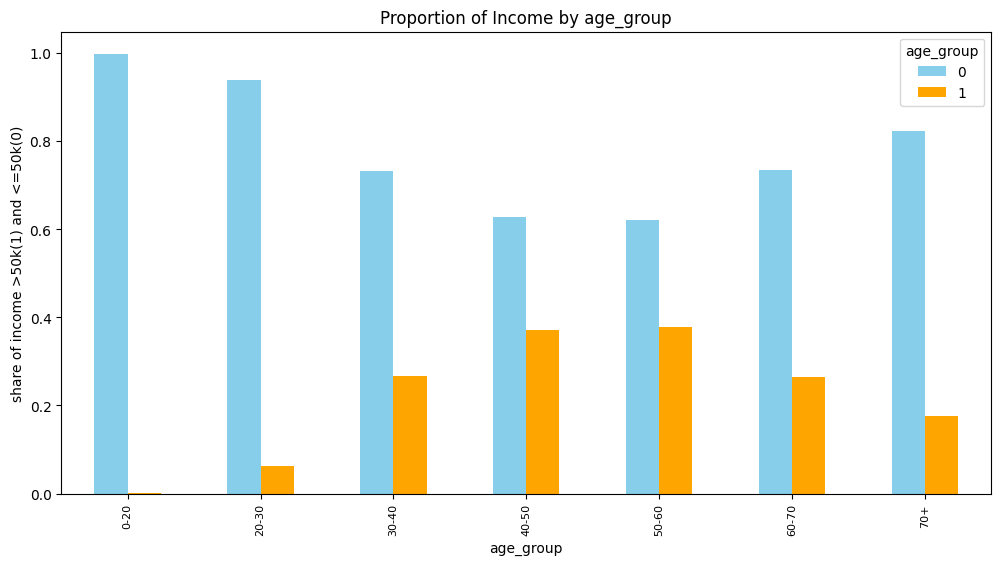

In [23]:
warnings.filterwarnings('ignore', category=FutureWarning)


# age groupe, split by 10 years for smoothness
def age_group(age):
    if age < 20:
        return '0-20'
    elif 20 <= age < 30:
        return '20-30'
    elif 30 <= age < 40:
        return '30-40'
    elif 40 <= age < 50:
        return '40-50'
    elif 50 <= age < 60:
        return '50-60'
    elif 60 <= age < 70:
        return '60-70'
    else:
        return '70+'


df['age_group'] = df['age'].apply(age_group)
plot_income_share_distribution('age_group', df)

*Check a new work time category relationship with workclass*

State-gov


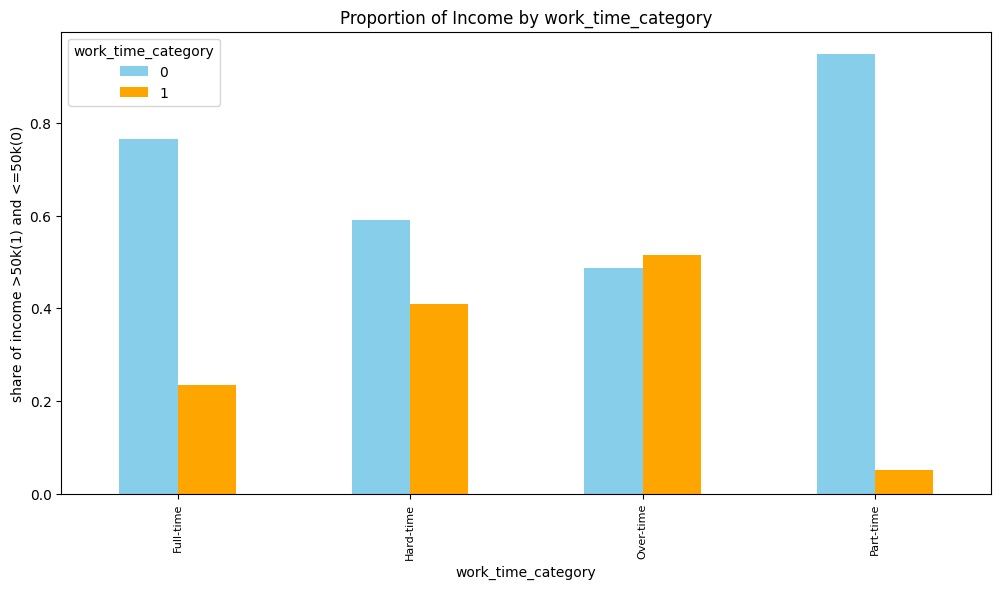



Self-emp-not-inc


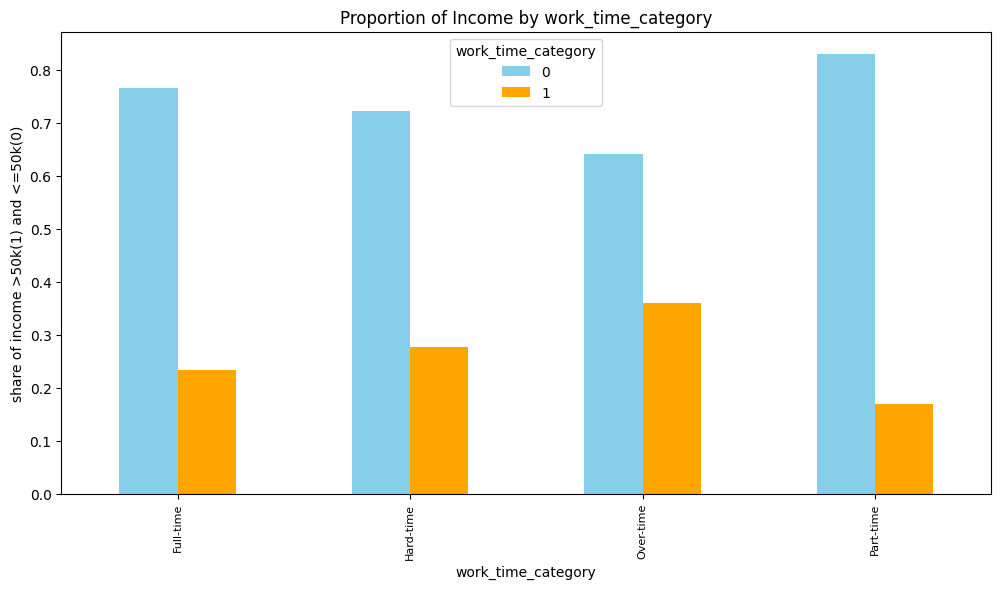



Private


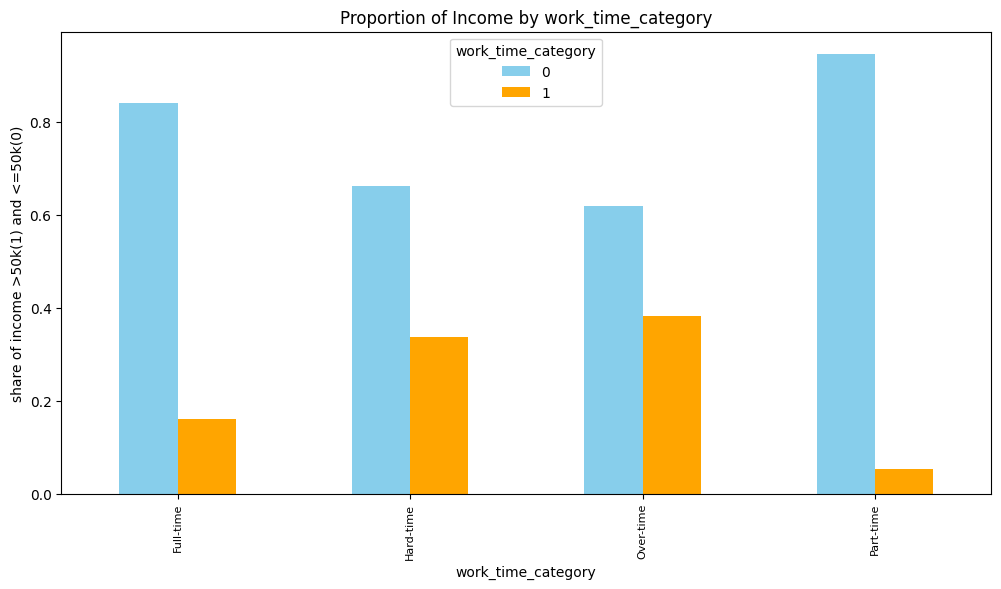



Federal-gov


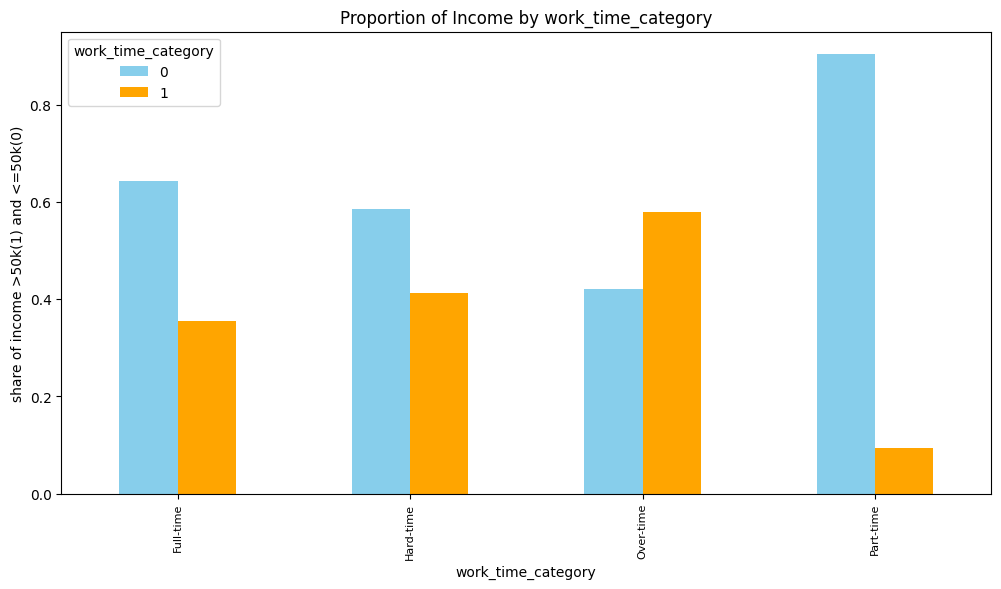



Local-gov


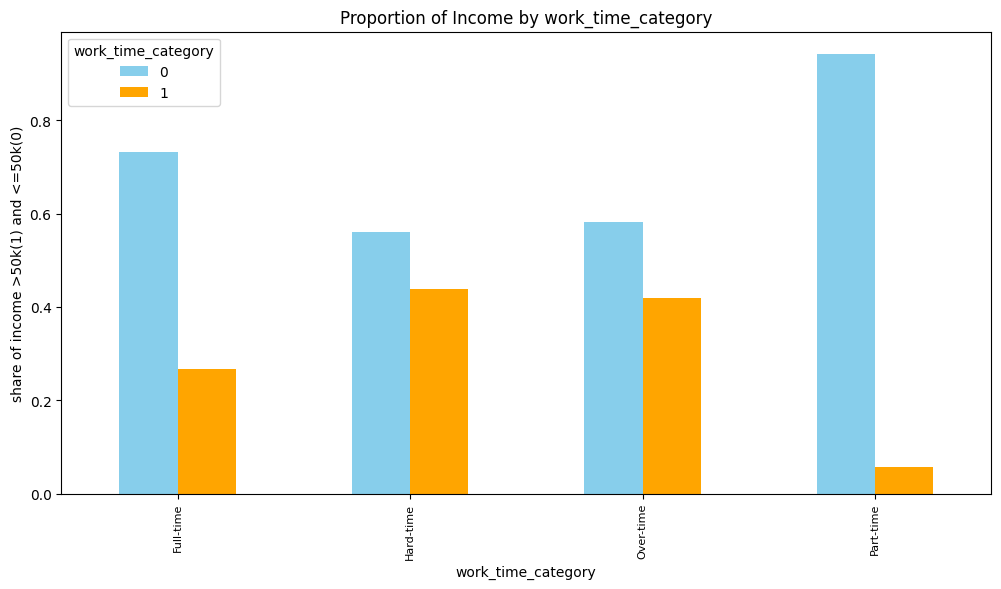



Self-emp-inc


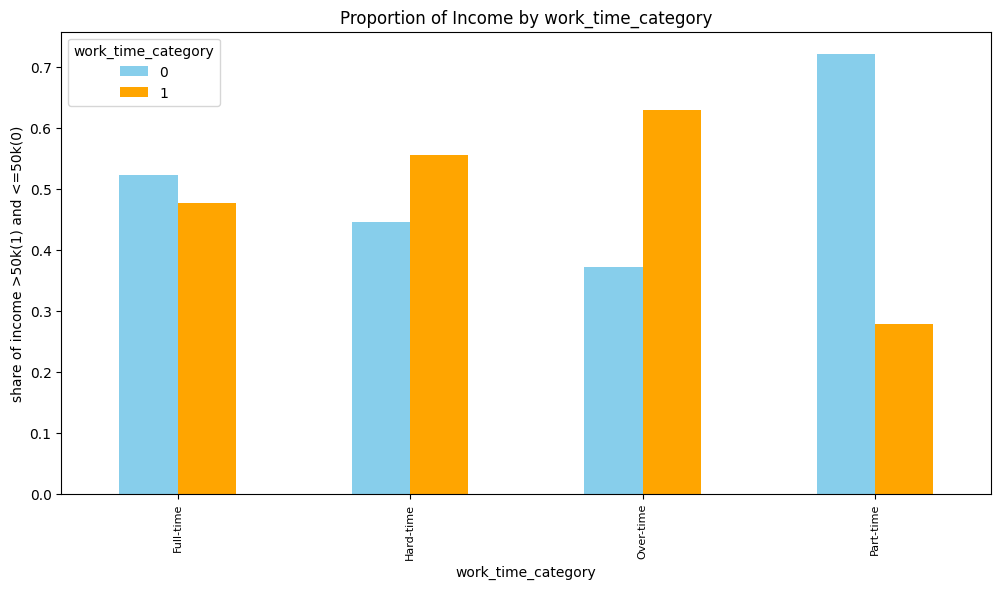



Without-pay


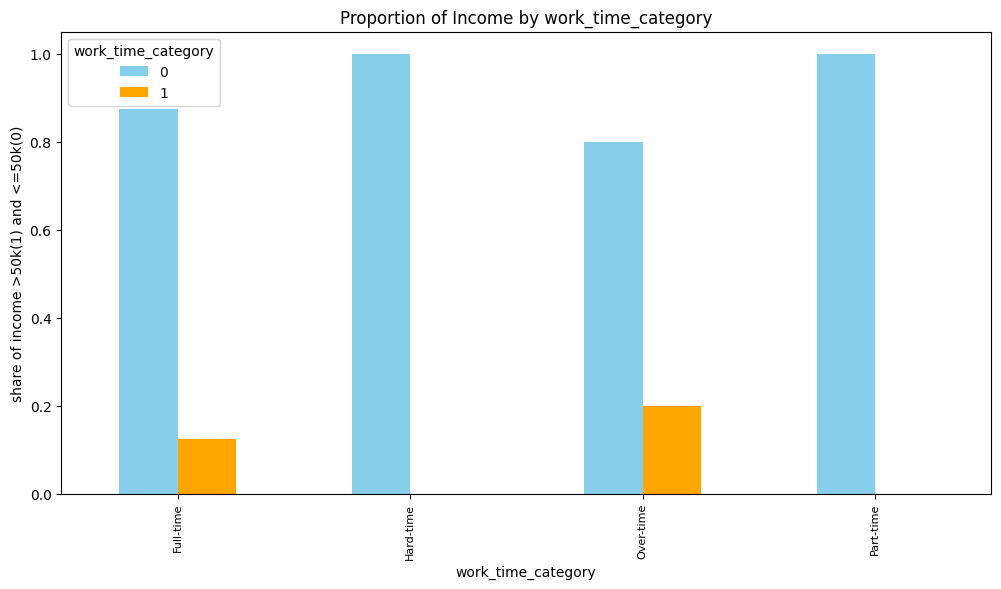



Never-worked


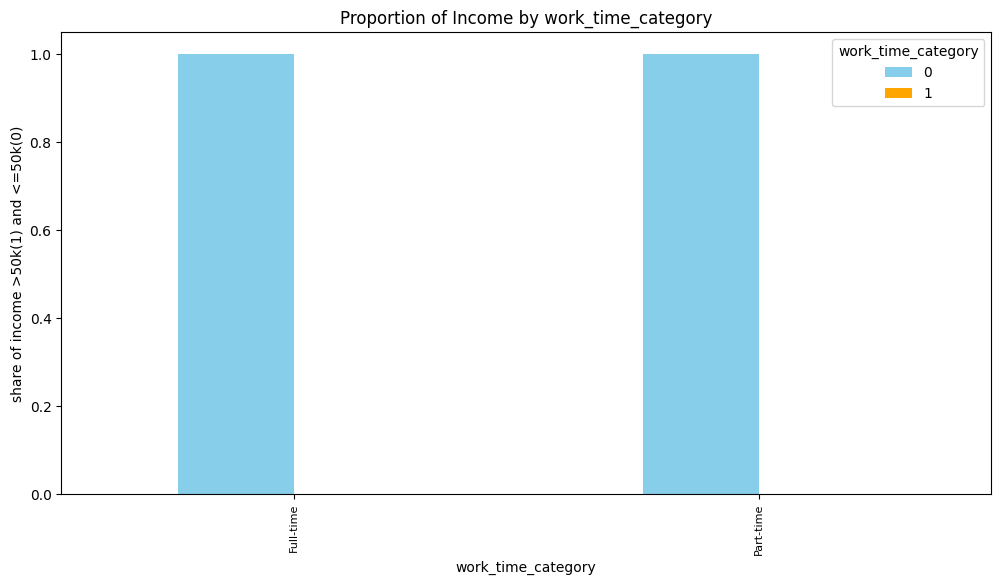

In [ ]:
warnings.filterwarnings('ignore', category=FutureWarning)

# check income distribution by workclass category
for wk_class in list(pd.unique(df['workclass'])):
    print(wk_class)
    plot_income_share_distribution('work_time_category', df.loc[df['workclass'] == wk_class])
    print('\n')

<a id="featureselection"></a>
**Feature selection**

Based on the graph and initial EDA I decide to choose next features:
- We have 2 features for education that have the same meaning, 'education' and 'educational-num'. I decide to use educational-num, because it's more representative.
- I categorize 'hour-per-week' and want to use it.
- I also categorize and binning 'Age' and it looks more appropriate
- other 3 numerical features capital-gaine & loss and fnlwgt - I provide standartization and delete outliers in the last one.
- And I also use remaining features

In real research, all the steps above are just initial ones, and we need to repeat them during model tuning, optimization, etc. To be honest, different strategies for handling each feature should be part of meta-hyperparameter optimization. However, the main goal here is not just to perform the best EDA analysis or find the best model, but to create a normal model that can be deployed after training.

<a id="modeldevelop"></a>
# Model development

<a id="datprep"></a>
# Data Preparation

First of all, we should provide label encoding for all categorical features and prepare data for training. Split data into train and test sets (I did it in the very beggining). Should notice, I think that it's better approach than one-hot-encoding.

Transform into label mapping. We will save data during applying that strategy for categorical features. And we will use that info in the inference part

In [34]:
# transform into label mapping.

label_mappings = {}
cat_columns = ['age_group','work_time_category', 'workclass', 'marital-status', 'occupation',
               'relationship', 'race', 'sex', 'native-country', 'income']


for col in cat_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))


*Split data into 3 part for Training, Evaluation and test dataset*

In [35]:
# derive data and split for 3 part

features_learning = ['age_group','work_time_category', 'workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country',
                     'education-num', 'capital-gain_scale', 'capital-loss_scale', 'fnlwgt_scale',
                     'income']


df_model = copy.deepcopy(df[features_learning])
df_train = df_model.loc[index_train]
df_test = df_model.loc[index_test]


x_train, x_val, y_train, y_val = train_test_split(df_train.drop(columns=['income']), df_train['income'], test_size=0.2, random_state=42)
x_test = df_test.drop(columns=['income'])
y_test = df_test['income']

Show final cross correlation matrix for our features

In the next iteration, I would logically group the factors and build components from them, and then construct the model based on these components.

I would also leave just one factor, either 'relationship' or 'marital-status.' Given the strong correlation between 'marital-status' and 'sex,' I would try removing 'marital-status' first.

In fact, I didn't perform a thorough feature selection or detailed work with different features here, but rather approached this topic superficially. For educational purposes, this is applicable.

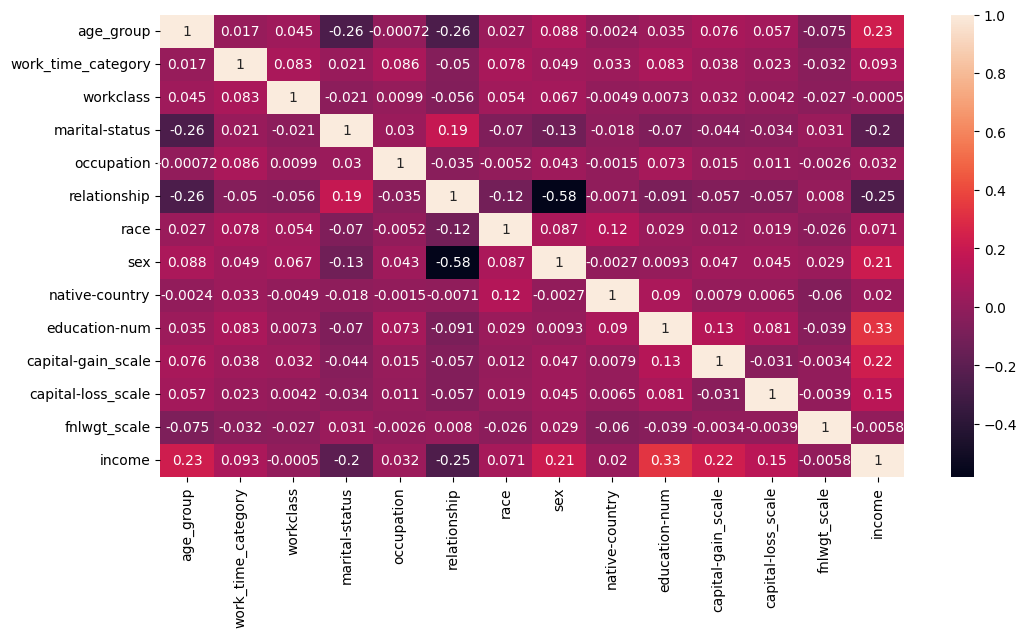

In [37]:
fig, ax = plt.subplots(figsize=(12,6))
df_model_corr_mat = df_model.corr()
sns.heatmap(df_model_corr_mat, annot=True);

<a id="modelchoos"></a>
# Model choosing

Provide some experiments with defferent type of models which were taken out-of-box without tuning

In [40]:
# create a function to obtain metrics

def model_eval(actual, pred):

    out = {}
    out['accuracy'] =  accuracy_score(actual, pred)
    out['precision'] = precision_score(actual, pred)
    out['recall'] = recall_score(actual, pred)
    out['f_measure'] = f1_score(actual, pred)

    return out

In [41]:
# batch of models

models = {
    'LogisticRegression': LogisticRegression(penalty = 'l2'),
    'RandomForestClassifier': RandomForestClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'CatBoostClassifier': CatBoostClassifier()
}

Training loops for each model and save metrics

In [42]:
warnings.filterwarnings('ignore', category=FutureWarning)

model_metrics = pd.DataFrame()
roc_results = {}
roc_auc_res = {}

for name, model in models.items():

    print(f"Model: {name}")

    # fit model and get validation results
    model.fit(x_train, y_train);
    y_pred = model.predict(x_val)
    y_proba = model.predict_proba(x_val)[:, 1]

    # get metrics results
    model_metrics[name] = model_eval(y_val, y_pred)
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    roc_results[name+'_fpr'] = fpr
    roc_results[name+'_tpr'] = tpr
    roc_auc_res[name] = auc(fpr, tpr)

model_metrics = pd.concat([model_metrics, pd.DataFrame([roc_auc_res], index=['roc_auc'])])

Model: LogisticRegression


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model: RandomForestClassifier
Model: GradientBoostingClassifier
Model: CatBoostClassifier
Learning rate set to 0.041432
0:	learn: 0.6518847	total: 60.5ms	remaining: 1m
1:	learn: 0.6158922	total: 69.3ms	remaining: 34.6s
2:	learn: 0.5857987	total: 77.3ms	remaining: 25.7s
3:	learn: 0.5575237	total: 84.6ms	remaining: 21.1s
4:	learn: 0.5302401	total: 93.9ms	remaining: 18.7s
5:	learn: 0.5092966	total: 102ms	remaining: 16.9s
6:	learn: 0.4906728	total: 110ms	remaining: 15.6s
7:	learn: 0.4747846	total: 118ms	remaining: 14.6s
8:	learn: 0.4593484	total: 126ms	remaining: 13.9s
9:	learn: 0.4464083	total: 138ms	remaining: 13.7s
10:	learn: 0.4343786	total: 146ms	remaining: 13.2s
11:	learn: 0.4240279	total: 155ms	remaining: 12.7s
12:	learn: 0.4158172	total: 163ms	remaining: 12.4s
13:	learn: 0.4073961	total: 171ms	remaining: 12s
14:	learn: 0.3986711	total: 180ms	remaining: 11.8s
15:	learn: 0.3924323	total: 187ms	remaining: 11.5s
16:	learn: 0.3871272	total: 195ms	remaining: 11.3s
17:	learn: 0.3829133	to

<a id="modelchoosmetrics"></a>
Here are metrics for each model

In [43]:
model_metrics

,LogisticRegression,RandomForestClassifier,GradientBoostingClassifier,CatBoostClassifier
accuracy,0.824985,0.850338,0.866165,0.873387
precision,0.724371,0.720702,0.801483,0.791760
recall,0.467249,0.640674,0.606987,0.659389
f_measure,0.568070,0.678336,0.690806,0.719537
roc_auc,0.853515,0.898645,0.916588,0.926732


**Plot ROC curve for our box classifiers**

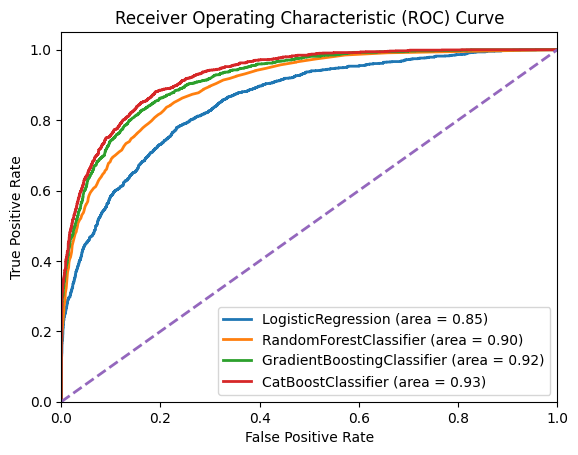

In [44]:
# graph ROC-curve

for name, model in models.items():

    fpr = roc_results[name+'_fpr']
    tpr = roc_results[name+'_tpr']

    plt.plot(fpr, tpr, lw=2, label=name + ' (area = %0.2f)' % roc_auc_res[name])


plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


<a id="modeltraing"></a>
# Model training

From the model development part we can say that it's better to focus on the training RandomForest and Catboost model. We focus on them because they have better recall metrics, although the difference in other metrics is not significant. Let's train them with hyperparameter optimization on the validation set. Then, we will choose the best model and save it.

In [45]:
# function for get metrics
def train_and_evaluate(name, model, x_train, y_train, x_val, y_val):

    roc_results = {}
    out = {}

    model.fit(x_train, y_train)
    pred = model.predict(x_val)
    pred_proba = model.predict_proba(x_val)[:, 1]

    out['accuracy'] =  accuracy_score(y_val, pred)
    out['precision'] = precision_score(y_val, pred)
    out['recall'] = recall_score(y_val, pred)
    out['f_measure'] = f1_score(y_val, pred)
    fpr, tpr, _ = roc_curve(y_val, pred_proba)
    roc_results[name+'_fpr'] = fpr
    roc_results[name+'_tpr'] = tpr

    return out, roc_results

model_metrics = pd.DataFrame()

**Train RandomForest model with different hyperparameters set**

In [ ]:
warnings.filterwarnings('ignore', category=FutureWarning)


rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 15],
    'class_weight': [{0:1, 1:1}, {0:1, 1:5}, {0:1, 1:10}],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt']
}


rf_model = RandomForestClassifier(random_state = 42)
rf_random = RandomizedSearchCV(estimator = rf_model,
                               param_distributions = rf_params,
                               n_iter = 20,
                               cv = 3,
                               verbose = 2,
                               random_state = 42,
                               n_jobs = -1)
rf_random.fit(x_train, y_train)
best_rf = rf_random.best_estimator_
out_val_rf, roc_results_val_rf = train_and_evaluate('RF', best_rf, x_train, y_train, x_val, y_val)
model_metrics['RandomForest'] = out_val_rf


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [ ]:
best_rf

RandomForestClassifier(class_weight={0: 1, 1: 1}, max_depth=15,
                       min_samples_leaf=2, min_samples_split=10,
                       random_state=42)

**Train Catboost with different hyperparameters set**

In [ ]:
cat_params = {
    'iterations': [100, 200, None],
    'learning_rate': [0.01, 0.1, 0.3, None],
    'depth': [4, 6, 8, None],
    'l2_leaf_reg': [1, 5, 7, 9, None]
}

cat_model = CatBoostClassifier(random_state = 42,
                               verbose = 0)
cat_random = RandomizedSearchCV(estimator = cat_model,
                                param_distributions = cat_params,
                                n_iter = 20,
                                cv = 4,
                                verbose = 2,
                                random_state = 42,
                                n_jobs = -1)
cat_random.fit(x_train, y_train)

best_cat = cat_random.best_estimator_
out_val_cat, roc_results_val_cat = train_and_evaluate('Catboost', best_cat, x_train, y_train, x_val, y_val)
model_metrics['Catboost'] = out_val_cat



Fitting 4 folds for each of 20 candidates, totalling 80 fits


In [ ]:
best_cat

<a id="result"></a>
# Results

Here we obtain result for our feature importence. It's valuable and we can use it for the next iteration model development and feature selection.

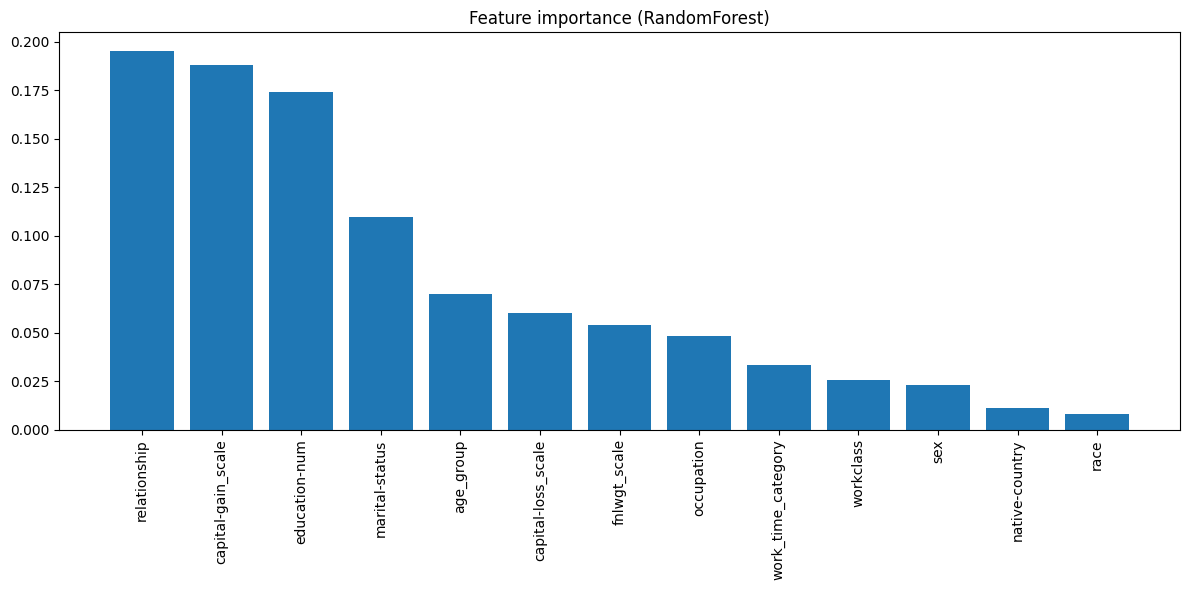

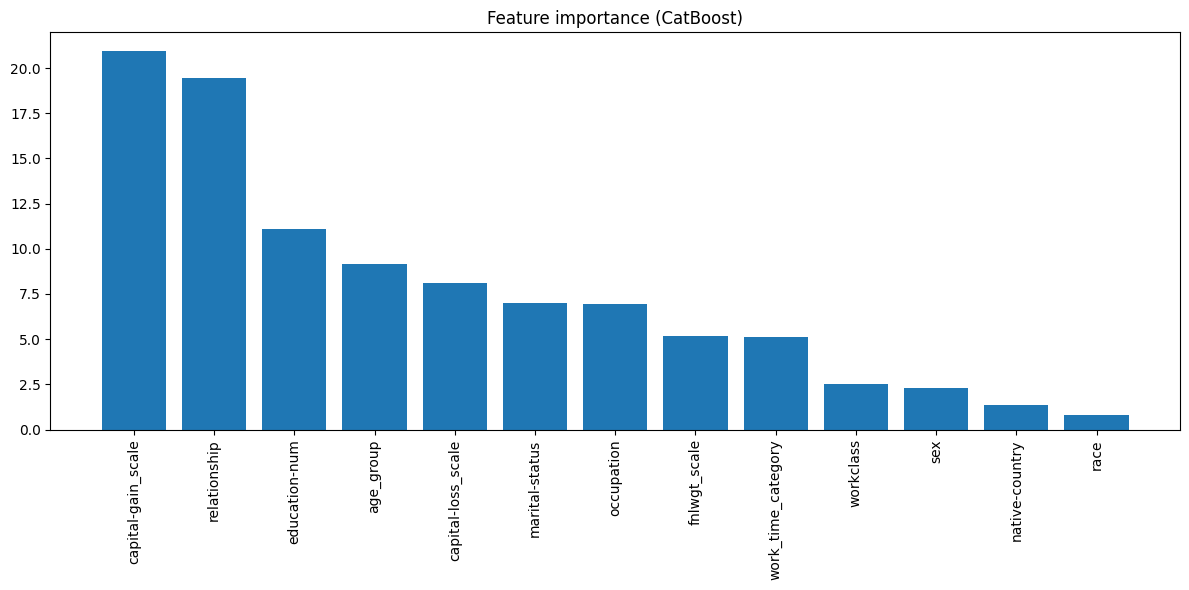

In [ ]:

# results of the best model on the test set
out_test_rf, roc_results_test_rf = train_and_evaluate('RF', best_rf, x_train, y_train, x_test, y_test)
out_test_cat, roc_results_test_cat = train_and_evaluate('Catboost', best_cat, x_train, y_train, x_test, y_test)


# Importance for RandomForest
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = x_train.columns

plt.figure(figsize=(12, 6))
plt.title("Feature importance (RandomForest)")
plt.bar(range(x_train.shape[1]), importances[indices])
plt.xticks(range(x_train.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()


# Importance for Catboost
feature_importance = best_cat.get_feature_importance()
sorted_idx = np.argsort(feature_importance)[::-1]
feature_names = x_train.columns

plt.figure(figsize=(12, 6))
plt.title("Feature importance (CatBoost)")
plt.bar(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.xticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx], rotation=90)
plt.tight_layout()
plt.show()

Here is an interesting result for feature importance: capital gain and loss are very important. This means we need to handle them more carefully and apply the second strategy, but in the next iteration (in the next loop)

<a id="resmetr"></a>
**Here are results metrics and ROC-curve**

In [ ]:
model_metrics

,RandomForest,Catboost
accuracy,0.864782,0.874616
precision,0.800000,0.791698
recall,0.601372,0.666251
f_measure,0.686610,0.723577


<a id="resroc"></a>

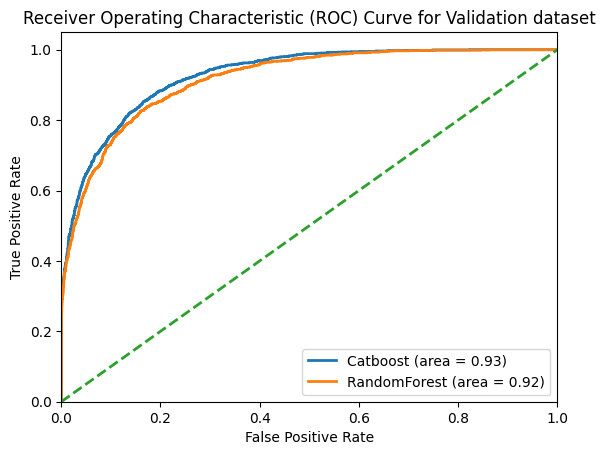

In [ ]:
# plot ROC-curve

fpr_cat = roc_results_val_cat['Catboost'+'_fpr']
tpr_cat = roc_results_val_cat['Catboost'+'_tpr']
fpr_rf = roc_results_val_rf['RF'+'_fpr']
tpr_rf = roc_results_val_rf['RF'+'_tpr']

plt.plot(fpr_cat, tpr_cat, lw=2, label='Catboost'+ ' (area = %0.2f)' % auc(fpr_cat, tpr_cat))
plt.plot(fpr_rf, tpr_rf, lw=2, label='RandomForest' + ' (area = %0.2f)' % auc(fpr_rf, tpr_rf))

plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Validation dataset')
plt.legend(loc='lower right')
plt.show()

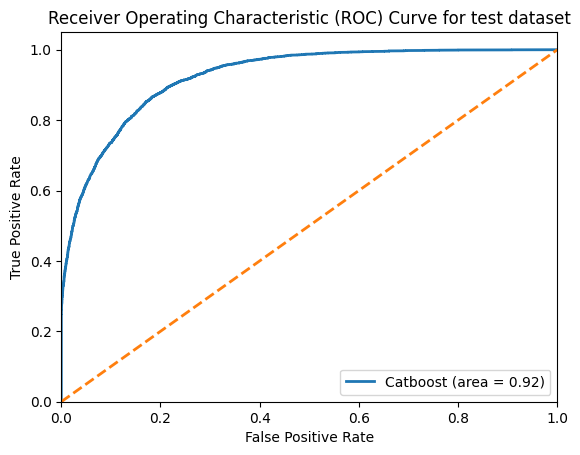

In [ ]:
# Final ROC-curve
fpr_cat = roc_results_test_cat['Catboost'+'_fpr']
tpr_cat = roc_results_test_cat['Catboost'+'_tpr']

plt.plot(fpr_cat, tpr_cat, lw=2, label='Catboost'+ ' (area = %0.2f)' % auc(fpr_cat, tpr_cat))

plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for test dataset')
plt.legend(loc='lower right')
plt.show()

<a id="conclusion"></a>
# Conclusion

**Based on the brief EDA and model development we have shown that CatBoost is the best model to take into production. CatBoost outperforms the RandomForest model in F1-score and recall (and accuracy, of course), though it slightly concede in precision. Nevertheless, CatBoost appears to be the more suitable model.**

**It’s definitely not the best model for this prediction task, but it's a good start. To improve the model, we need to focus more on feature selection and data transformation, apply factor derivation, perform more precise outlier detection, and implement a smarter approach for handling capital-loss & gain. The next step is to create a deployable model for prediction.**

<a id="saveall"></a>
# Save model, label mappings etc. (technical section)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pickle
import json

In [447]:
with open('/content/drive/MyDrive/Colab Notebooks/catboost_model.pkl', 'wb') as f:
    pickle.dump(best_cat, f)

In [482]:
def convert_numpy_types(obj):
    if isinstance(obj, np.int64):
        return int(obj)
    elif isinstance(obj, dict):
        return {k: convert_numpy_types(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(i) for i in obj]
    else:
        return obj

label_mappings_serializable = convert_numpy_types(label_mappings)
mode_values_serializable = convert_numpy_types(mode_values)

In [457]:
with open('/content/drive/MyDrive/Colab Notebooks/label_mappings.json', 'w') as json_file:
    json.dump(label_mappings_serializable, json_file)

In [462]:
with open('/content/drive/MyDrive/Colab Notebooks/standart_scaler.json', 'w') as json_file:
    json.dump(mean_var_store, json_file)

In [483]:
with open('/content/drive/MyDrive/Colab Notebooks/mode_values.json', 'w') as json_file:
    json.dump(mode_values_serializable, json_file)

In [ ]:
!pip freeze > requirements.txt